<a href="https://colab.research.google.com/github/DevJLALW/ImageCaptionGeneratorCustomCNNWithLSTM/blob/main/ImageCaptionGenerationCustomCNNModelWithLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [ ]:
!kaggle datasets download -d jessicali9530/stl10

In [ ]:
!kaggle datasets download -d jyotilalwani/stl10dataset

In [ ]:
!unzip /kaggle/working/flickr8k.zip -d /kaggle/working/flickr8k

In [ ]:
!unzip /kaggle/working/stl10.zip -d /kaggle/working/stl10

In [ ]:
!unzip /kaggle/working/stl10dataset.zip -d /kaggle/working/stl10

In [ ]:
!mkdir /kaggle/working/flickr8k/working

In [ ]:
# !pip install wurlitzer

In [ ]:
# !pip install numpy==1.25.2
# !pip install pandas==2.0.3
# !pip install matplotlib==3.7.1
# !pip install tensorflow==2.15.0

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten

2024-07-18 11:04:50.899873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 11:04:50.899990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 11:04:51.014584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
BASE_DIR = '/kaggle/working/flickr8k'
WORKING_DIR = '/kaggle/working/flickr8k/working'

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [ ]:
def create_custom_model(input_shape=(96, 96, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Preprocessing and Data - Augmentation
    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal_and_vertical")(x)
    x = RandomRotation(0.2)(x)
    x = RandomZoom(0.2)(x)
    x = RandomTranslation(0.2, 0.2)(x)


    x = Conv2D(96, (11, 11), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Create and compile the custom model
custom_model = create_custom_model(input_shape=(96, 96, 3), num_classes=10)
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
custom_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 96, 96, 3)         0         
                                                                 
 random_rotation_2 (RandomR  (None, 96, 96, 3)         0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 96, 96, 3)         0         
                                                                 
 random_translation_1 (Rand  (None, 96, 96, 3)         0         
 omTranslation)                                            

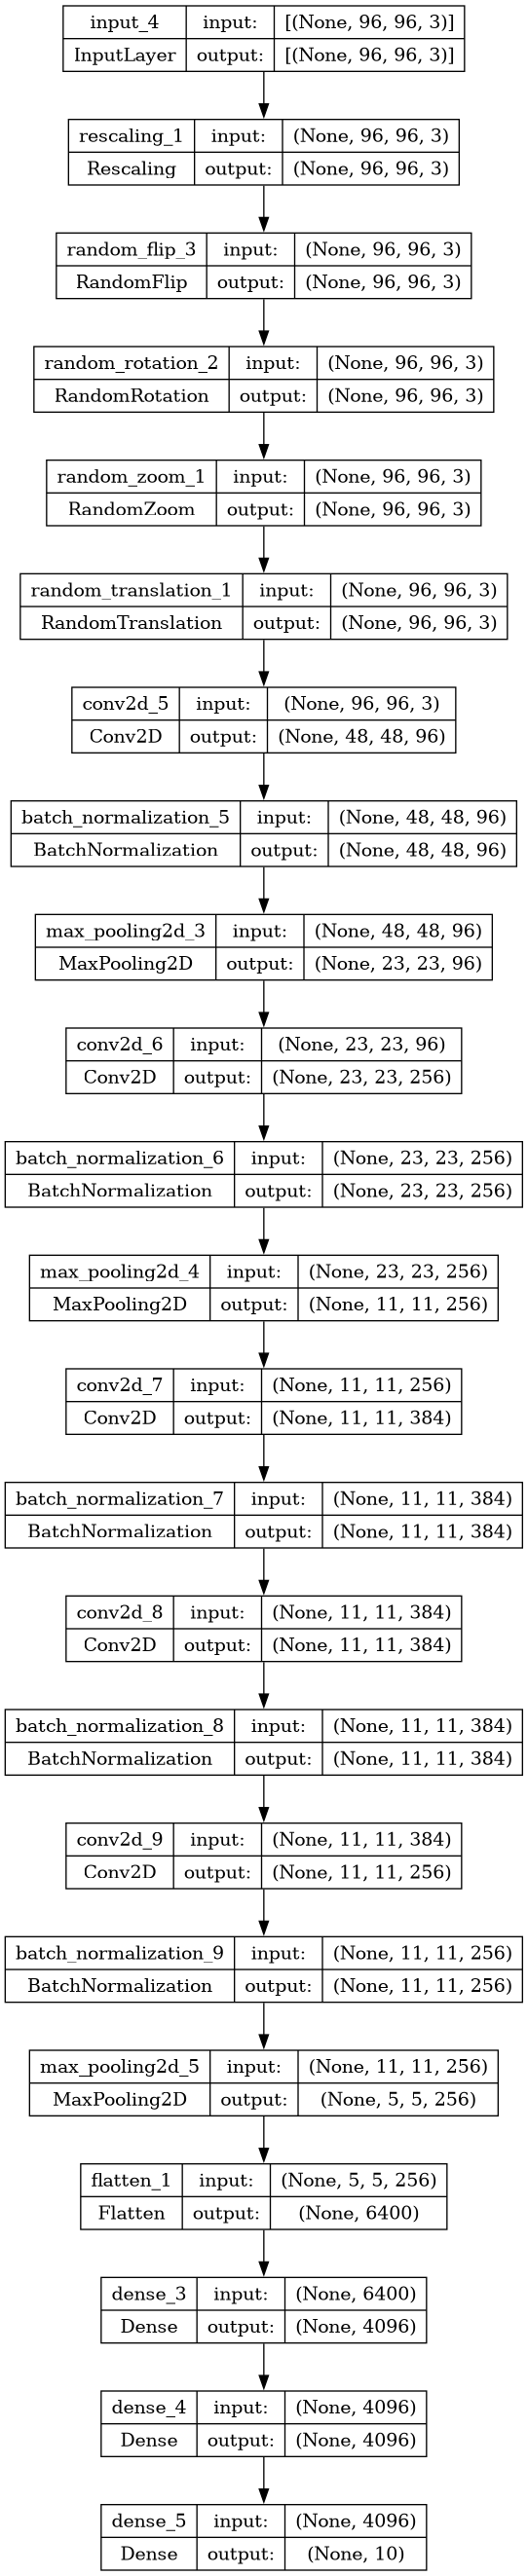

In [ ]:
from tensorflow.keras.utils import plot_model

model_custom = custom_model

# Plot the model and save it as an image file
plot_model(model_custom, to_file='model_summary.png', show_shapes=True, show_layer_names=True)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping

# print('startdata')
# # Load CIFAR-10 dataset
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# print('getdata')
# X_train = X_train[:6000]
# y_train = y_train[:6000]
# X_test = X_test[:500]
# y_test = y_test[:500]

# # Resize images from 32x32 to 224x224
# X_train_resized = tf.image.resize(X_train, (224, 224))
# X_test_resized = tf.image.resize(X_test, (224, 224))
# print('resizedata')

# # Convert labels to categorical format
# y_train_categorical = to_categorical(y_train, num_classes=10)
# y_test_categorical = to_categorical(y_test, num_classes=10)
# print('categoricaldata')

# # Normalize pixel values
# X_train_resized = X_train_resized / 255.0
# X_test_resized = X_test_resized / 255.0
# print('resize again')

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# # Create and compile the custom model
# custom_model = create_custom_model(input_shape=(224, 224, 3), num_classes=10)
# custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# print('custom model')

# # Training parameters
# batch_size = 32
# epochs = 10

# # Train the model with early stopping
# custom_model.fit(
#     X_train_resized, y_train_categorical,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=(X_test_resized, y_test_categorical),
#     callbacks=[early_stop]
# )

# # Evaluate the model on test data
# loss, accuracy = custom_model.evaluate(X_test_resized, y_test_categorical)
# print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
def load_stl10_data(json_file, base_dir, img_size=(96, 96)):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = []
    labels = []
    for item in data:
        img_path = os.path.join(base_dir, item['file'])
        image = load_img(img_path, target_size=img_size)
        image = img_to_array(image)
        images.append(image)
        labels.append(item['label'])

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int")

    return images, labels

# Load STL10 data
train_images, train_labels = load_stl10_data('/kaggle/working/stl10/train.json', '/kaggle/working/stl10')
test_images, test_labels = load_stl10_data('/kaggle/working/stl10/test.json', '/kaggle/working/stl10')

# Normalize images
#train_images /= 255.0
#test_images /= 255.0

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = custom_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


I0000 00:00:1721301098.467508     223 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 20s 74ms/step - loss: 2.3939 - accuracy: 0.2548 - val_loss: 2.8651 - val_accuracy: 0.1145 - lr: 1.0000e-04
Epoch 2/20
157/157 [==============================] - 9s 54ms/step - loss: 1.9078 - accuracy: 0.3006 - val_loss: 2.8097 - val_accuracy: 0.1404 - lr: 1.0000e-04
Epoch 3/20
157/157 [==============================] - 9s 55ms/step - loss: 1.8110 - accuracy: 0.3336 - val_loss: 2.0919 - val_accuracy: 0.2294 - lr: 1.0000e-04
Epoch 4/20
157/157 [==============================] - 9s 55ms/step - loss: 1.7644 - accuracy: 0.3434 - val_loss: 2.0490 - val_accuracy: 0.2973 - lr: 1.0000e-04
Epoch 5/20
157/157 [==============================] - 9s 55ms/step - loss: 1.7088 - accuracy: 0.3646 - val_loss: 1.7211 - val_accuracy: 0.3679 - lr: 1.0000e-04
Epoch 6/20
157/157 [==============================] - 9s 56ms/step - loss: 1.6623 - accuracy: 0.3824 - val_loss: 1.6021 - val_accuracy: 0.3790 - lr: 1.0000e-04
Epoch 7/20
157/157 [==============================

In [ ]:
import matplotlib.pyplot as plt

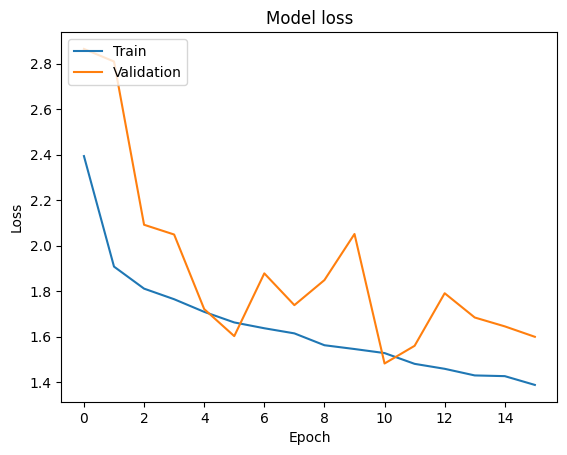

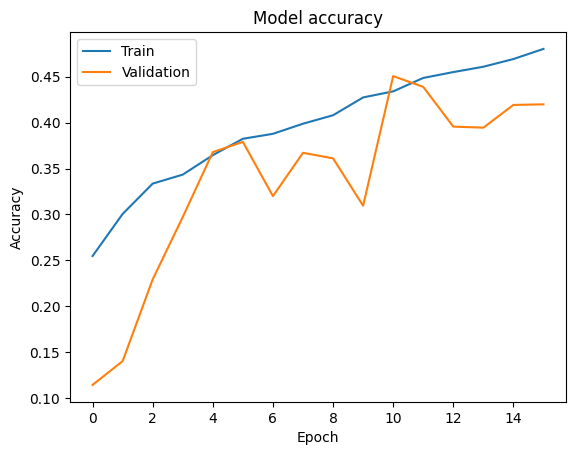

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# from tensorflow.keras.models import load_model, save_model

# save_model(custom_model, '/kaggle/working/flickr8k/working/custom_model.h5')

In [ ]:
# import tensorflow as tf
# # Delete unnecessary variables, models, etc.
# del custom_model
# # Reset TensorFlow session (optional)
# tf.keras.backend.clear_session()

In [ ]:
# from tensorflow.keras.models import load_model, save_model
# custom_model = load_model('/kaggle/working/flickr8k/working/custom_model.h5')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os
from tqdm import tqdm


feature_extractor = Model(inputs=custom_model.input, outputs=custom_model.layers[-2].output)

In [ ]:
# Function to extract features
def extract_features(model, directory, target_size=(96, 96)):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        # load the image from file
        img_path = os.path.join(directory, img_name)

        image = load_img(img_path, target_size=target_size)
        # convert image pixels to numpy array
        image = img_to_array(image)
        # normalize image (same normalization as used during model training)
        image = image / 255.0
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # extract features
        feature = model.predict(image)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature
    return features

In [ ]:
directory = os.path.join(BASE_DIR, 'Images')
features = extract_features(feature_extractor, directory)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 1s 616ms/step


  0%|          | 1/8091 [00:00<1:30:09,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/8091 [00:00<30:01,  4.49it/s]  

1/1 [==============================] - 0s 18ms/step


  0%|          | 5/8091 [00:00<18:57,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 7/8091 [00:01<14:31,  9.28it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 9/8091 [00:01<12:08, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 11/8091 [00:01<11:01, 12.22it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 13/8091 [00:01<10:10, 13.22it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 15/8091 [00:01<09:35, 14.04it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 17/8091 [00:01<09:30, 14.15it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 19/8091 [00:01<09:17, 14.48it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 21/8091 [00:01<09:02, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 23/8091 [00:02<08:55, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 25/8091 [00:02<08:50, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 27/8091 [00:02<08:48, 15.26it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 29/8091 [00:02<08:44, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 31/8091 [00:02<08:39, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 33/8091 [00:02<08:31, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 35/8091 [00:02<08:28, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 37/8091 [00:02<08:33, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 39/8091 [00:03<08:32, 15.72it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 41/8091 [00:03<08:33, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 43/8091 [00:03<08:35, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 45/8091 [00:03<08:29, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 47/8091 [00:03<08:31, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 49/8091 [00:03<08:21, 16.04it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 51/8091 [00:03<08:22, 15.98it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 53/8091 [00:03<08:22, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 55/8091 [00:04<08:30, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 57/8091 [00:04<08:31, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 59/8091 [00:04<08:35, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 61/8091 [00:04<08:35, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 63/8091 [00:04<08:34, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 65/8091 [00:04<08:36, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 67/8091 [00:04<08:32, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 69/8091 [00:05<08:27, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 71/8091 [00:05<08:24, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 73/8091 [00:05<08:30, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 75/8091 [00:05<08:23, 15.91it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 77/8091 [00:05<08:21, 15.97it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 79/8091 [00:05<08:23, 15.90it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 81/8091 [00:05<08:22, 15.96it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 83/8091 [00:05<08:31, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 85/8091 [00:06<08:27, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 87/8091 [00:06<08:23, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 89/8091 [00:06<08:25, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 91/8091 [00:06<08:34, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 93/8091 [00:06<08:30, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 95/8091 [00:06<08:26, 15.80it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 97/8091 [00:06<08:23, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 99/8091 [00:06<08:20, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 101/8091 [00:07<08:25, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 103/8091 [00:07<08:25, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 105/8091 [00:07<08:22, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 107/8091 [00:07<08:22, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 109/8091 [00:07<08:27, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 111/8091 [00:07<08:24, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 113/8091 [00:07<08:22, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 115/8091 [00:07<08:16, 16.07it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 117/8091 [00:08<08:15, 16.08it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 119/8091 [00:08<08:27, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 121/8091 [00:08<08:22, 15.85it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 123/8091 [00:08<08:54, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 125/8091 [00:08<08:46, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 127/8091 [00:08<08:33, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 129/8091 [00:08<08:36, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 131/8091 [00:08<08:28, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 133/8091 [00:09<08:24, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 135/8091 [00:09<08:21, 15.88it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 137/8091 [00:09<08:27, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 139/8091 [00:09<08:25, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 141/8091 [00:09<08:19, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 143/8091 [00:09<08:22, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 145/8091 [00:09<08:19, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 147/8091 [00:09<08:24, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 149/8091 [00:10<08:23, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 151/8091 [00:10<08:21, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 153/8091 [00:10<08:16, 15.99it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 155/8091 [00:10<08:19, 15.88it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 157/8091 [00:10<08:20, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 159/8091 [00:10<08:35, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 161/8091 [00:10<08:30, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 163/8091 [00:10<08:27, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 165/8091 [00:11<08:33, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 167/8091 [00:11<08:44, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 169/8091 [00:11<08:36, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 171/8091 [00:11<08:32, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 173/8091 [00:11<08:38, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 175/8091 [00:11<08:35, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 177/8091 [00:11<08:36, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 179/8091 [00:12<08:31, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 181/8091 [00:12<08:27, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 183/8091 [00:12<08:47, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 185/8091 [00:12<08:35, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 187/8091 [00:12<08:29, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 189/8091 [00:12<08:27, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 191/8091 [00:12<08:27, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 193/8091 [00:12<08:21, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 195/8091 [00:13<08:18, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 197/8091 [00:13<08:16, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 199/8091 [00:13<08:18, 15.83it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 201/8091 [00:13<08:24, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 203/8091 [00:13<08:22, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 205/8091 [00:13<08:18, 15.83it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 207/8091 [00:13<08:12, 16.02it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 209/8091 [00:13<08:15, 15.90it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 211/8091 [00:14<08:11, 16.02it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 213/8091 [00:14<08:12, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 215/8091 [00:14<08:12, 15.99it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 217/8091 [00:14<08:16, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 219/8091 [00:14<08:23, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 221/8091 [00:14<08:24, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 223/8091 [00:14<08:19, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 225/8091 [00:14<08:15, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 227/8091 [00:15<08:19, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 229/8091 [00:15<08:17, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 231/8091 [00:15<08:16, 15.83it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 233/8091 [00:15<08:14, 15.88it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 235/8091 [00:15<08:12, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 237/8091 [00:15<08:19, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 239/8091 [00:15<08:17, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 241/8091 [00:15<08:16, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 243/8091 [00:16<08:17, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 245/8091 [00:16<08:14, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 247/8091 [00:16<08:17, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 249/8091 [00:16<08:21, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 251/8091 [00:16<08:17, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 253/8091 [00:16<08:13, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 255/8091 [00:16<08:21, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 257/8091 [00:16<08:15, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 259/8091 [00:17<08:16, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 261/8091 [00:17<08:15, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 263/8091 [00:17<08:18, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 265/8091 [00:17<08:15, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 267/8091 [00:17<08:17, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 269/8091 [00:17<08:14, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 271/8091 [00:17<08:10, 15.94it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 273/8091 [00:17<08:16, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 275/8091 [00:18<08:12, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 277/8091 [00:18<08:25, 15.46it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 279/8091 [00:18<08:37, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 281/8091 [00:18<08:42, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 283/8091 [00:18<08:31, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 285/8091 [00:18<08:25, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 287/8091 [00:18<08:17, 15.67it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 289/8091 [00:19<08:17, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 291/8091 [00:19<08:20, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 293/8091 [00:19<08:19, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 295/8091 [00:19<08:18, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 297/8091 [00:19<08:14, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 299/8091 [00:19<08:14, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 301/8091 [00:19<08:12, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 303/8091 [00:19<08:11, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 305/8091 [00:20<08:08, 15.93it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 307/8091 [00:20<08:04, 16.06it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 309/8091 [00:20<08:10, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 311/8091 [00:20<08:08, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 313/8091 [00:20<08:05, 16.03it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 315/8091 [00:20<08:06, 15.97it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 317/8091 [00:20<08:08, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 319/8091 [00:20<08:05, 15.99it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 321/8091 [00:21<08:04, 16.03it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 323/8091 [00:21<08:05, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 325/8091 [00:21<08:05, 15.99it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 327/8091 [00:21<08:07, 15.92it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 329/8091 [00:21<08:11, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 331/8091 [00:21<08:10, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 333/8091 [00:21<08:08, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 335/8091 [00:21<08:16, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 337/8091 [00:22<08:15, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 339/8091 [00:22<08:14, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 341/8091 [00:22<08:12, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 343/8091 [00:22<08:09, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 345/8091 [00:22<08:15, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 347/8091 [00:22<08:11, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 349/8091 [00:22<08:07, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 351/8091 [00:22<08:04, 15.97it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 353/8091 [00:23<08:09, 15.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 355/8091 [00:23<08:10, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 357/8091 [00:23<08:11, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 359/8091 [00:23<08:10, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 361/8091 [00:23<08:05, 15.92it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 363/8091 [00:24<14:57,  8.61it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 365/8091 [00:24<13:10,  9.77it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 367/8091 [00:24<11:46, 10.93it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 369/8091 [00:24<10:51, 11.85it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 371/8091 [00:24<10:10, 12.64it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 373/8091 [00:24<09:51, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 375/8091 [00:24<09:53, 13.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 377/8091 [00:25<09:43, 13.21it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 379/8091 [00:25<10:05, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 381/8091 [00:25<10:13, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 383/8091 [00:25<10:04, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 385/8091 [00:25<09:46, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 387/8091 [00:25<09:36, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 389/8091 [00:25<09:26, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 391/8091 [00:26<09:17, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 393/8091 [00:26<09:07, 14.05it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 395/8091 [00:26<08:57, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 397/8091 [00:26<08:45, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 399/8091 [00:26<08:41, 14.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 401/8091 [00:26<08:31, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 403/8091 [00:26<08:29, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 405/8091 [00:26<08:23, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 407/8091 [00:27<08:17, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 409/8091 [00:27<08:25, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 411/8091 [00:27<08:20, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 413/8091 [00:27<08:16, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 415/8091 [00:27<08:12, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 417/8091 [00:27<08:16, 15.45it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 419/8091 [00:27<08:15, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 421/8091 [00:28<08:10, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 423/8091 [00:28<08:19, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 425/8091 [00:28<08:14, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 427/8091 [00:28<08:55, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 429/8091 [00:28<08:41, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 431/8091 [00:28<08:32, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 433/8091 [00:28<08:20, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 435/8091 [00:28<08:23, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 437/8091 [00:29<08:14, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 439/8091 [00:29<08:11, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 441/8091 [00:29<08:09, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 443/8091 [00:29<08:13, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 445/8091 [00:29<08:20, 15.29it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 447/8091 [00:29<08:20, 15.27it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 449/8091 [00:29<08:31, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 451/8091 [00:30<08:22, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 453/8091 [00:30<08:23, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 455/8091 [00:30<08:18, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 457/8091 [00:30<08:15, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 459/8091 [00:30<08:15, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 461/8091 [00:30<08:05, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 463/8091 [00:30<08:12, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 465/8091 [00:30<08:08, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 467/8091 [00:31<08:07, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 469/8091 [00:31<08:06, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 471/8091 [00:31<08:09, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 473/8091 [00:31<08:08, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 475/8091 [00:31<08:07, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 477/8091 [00:31<08:09, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 479/8091 [00:31<08:11, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 481/8091 [00:31<08:19, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 483/8091 [00:32<08:13, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 485/8091 [00:32<08:13, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 487/8091 [00:32<08:12, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 489/8091 [00:32<08:15, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 491/8091 [00:32<08:15, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 493/8091 [00:32<08:14, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 495/8091 [00:32<08:13, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 497/8091 [00:32<08:10, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 499/8091 [00:33<08:13, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 501/8091 [00:33<08:13, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 503/8091 [00:33<08:12, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 505/8091 [00:33<08:04, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 507/8091 [00:33<08:08, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 509/8091 [00:33<08:08, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 511/8091 [00:33<08:06, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 513/8091 [00:34<08:05, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 515/8091 [00:34<08:01, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 517/8091 [00:34<08:07, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 519/8091 [00:34<08:06, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 521/8091 [00:34<08:07, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 523/8091 [00:34<08:04, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 525/8091 [00:34<08:17, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 527/8091 [00:34<08:16, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 529/8091 [00:35<08:09, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 531/8091 [00:35<08:07, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 533/8091 [00:35<08:06, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 535/8091 [00:35<08:11, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 537/8091 [00:35<08:07, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 539/8091 [00:35<08:06, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 541/8091 [00:35<08:01, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 543/8091 [00:35<08:09, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 545/8091 [00:36<08:01, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 547/8091 [00:36<08:06, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 549/8091 [00:36<08:05, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 551/8091 [00:36<08:04, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 553/8091 [00:36<08:07, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 555/8091 [00:36<08:06, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 557/8091 [00:36<08:07, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 559/8091 [00:36<08:08, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 561/8091 [00:37<08:08, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 563/8091 [00:37<08:03, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 565/8091 [00:37<08:03, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 567/8091 [00:37<08:01, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 569/8091 [00:37<07:57, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 571/8091 [00:37<08:05, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 573/8091 [00:37<08:01, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 575/8091 [00:38<07:59, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 577/8091 [00:38<07:55, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 579/8091 [00:38<08:02, 15.58it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 581/8091 [00:38<08:27, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 583/8091 [00:38<08:23, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 585/8091 [00:38<08:13, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 587/8091 [00:38<08:08, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 589/8091 [00:38<08:15, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 591/8091 [00:39<08:16, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 593/8091 [00:39<08:10, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 595/8091 [00:39<08:10, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 597/8091 [00:39<08:24, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 599/8091 [00:39<08:19, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 601/8091 [00:39<08:15, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 603/8091 [00:39<08:08, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 605/8091 [00:39<08:01, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 607/8091 [00:40<08:06, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 609/8091 [00:40<08:07, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 611/8091 [00:40<08:02, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 613/8091 [00:40<07:57, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 615/8091 [00:40<08:03, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 617/8091 [00:40<08:01, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 619/8091 [00:40<07:58, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 621/8091 [00:41<07:55, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 623/8091 [00:41<07:50, 15.88it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 625/8091 [00:41<07:58, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 627/8091 [00:41<07:52, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 629/8091 [00:41<07:52, 15.78it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 631/8091 [00:41<07:51, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 633/8091 [00:41<07:59, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 635/8091 [00:41<07:59, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 637/8091 [00:42<07:58, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 639/8091 [00:42<07:56, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 641/8091 [00:42<07:52, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 643/8091 [00:42<07:58, 15.58it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 645/8091 [00:42<07:54, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 647/8091 [00:42<07:52, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 649/8091 [00:42<07:54, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 651/8091 [00:42<07:57, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 653/8091 [00:43<07:52, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 655/8091 [00:43<07:55, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 657/8091 [00:43<08:03, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 659/8091 [00:43<07:59, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 661/8091 [00:43<08:02, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 663/8091 [00:43<07:54, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 665/8091 [00:43<07:54, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 667/8091 [00:43<07:54, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 669/8091 [00:44<07:56, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 671/8091 [00:44<07:54, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 673/8091 [00:44<07:53, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 675/8091 [00:44<07:53, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 677/8091 [00:44<07:54, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 679/8091 [00:44<07:58, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 681/8091 [00:44<07:54, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 683/8091 [00:44<07:54, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 685/8091 [00:45<07:50, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 687/8091 [00:45<07:50, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 689/8091 [00:45<07:50, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 691/8091 [00:45<07:49, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 693/8091 [00:45<07:45, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 695/8091 [00:45<07:47, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 697/8091 [00:45<07:54, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 699/8091 [00:45<07:53, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 701/8091 [00:46<07:55, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 703/8091 [00:46<07:50, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 705/8091 [00:46<08:00, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 707/8091 [00:46<07:55, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 709/8091 [00:46<07:48, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 711/8091 [00:46<07:46, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 713/8091 [00:46<07:49, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 715/8091 [00:47<07:54, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 717/8091 [00:47<07:52, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 719/8091 [00:47<07:52, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 721/8091 [00:47<07:45, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 723/8091 [00:47<07:50, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 725/8091 [00:47<07:51, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 727/8091 [00:47<07:55, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 729/8091 [00:47<07:51, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 731/8091 [00:48<07:46, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 733/8091 [00:48<07:58, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 735/8091 [00:48<07:55, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 737/8091 [00:48<08:18, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 739/8091 [00:48<08:16, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 741/8091 [00:48<08:18, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 743/8091 [00:48<08:09, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 745/8091 [00:48<08:04, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 747/8091 [00:49<07:58, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 749/8091 [00:49<07:53, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 751/8091 [00:49<07:58, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 753/8091 [00:49<07:55, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 755/8091 [00:49<07:52, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 757/8091 [00:49<07:50, 15.58it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 759/8091 [00:49<08:07, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 761/8091 [00:50<08:05, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 763/8091 [00:50<08:03, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 765/8091 [00:50<07:59, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 767/8091 [00:50<07:54, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 769/8091 [00:50<08:00, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 771/8091 [00:50<07:54, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 773/8091 [00:50<08:02, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 775/8091 [00:50<07:56, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 777/8091 [00:51<07:59, 15.27it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 779/8091 [00:51<07:58, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 781/8091 [00:51<07:57, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 783/8091 [00:51<07:53, 15.42it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 785/8091 [00:51<07:46, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 787/8091 [00:51<07:50, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 789/8091 [00:51<07:53, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 791/8091 [00:51<07:57, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 793/8091 [00:52<07:56, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 795/8091 [00:52<07:53, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 797/8091 [00:52<07:48, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 799/8091 [00:52<07:43, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 801/8091 [00:52<07:42, 15.75it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 803/8091 [00:52<07:43, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 805/8091 [00:52<07:47, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 807/8091 [00:52<07:39, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 809/8091 [00:53<07:38, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 811/8091 [00:53<07:39, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 813/8091 [00:53<07:47, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 815/8091 [00:53<07:48, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 817/8091 [00:53<07:45, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 819/8091 [00:53<07:44, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 821/8091 [00:53<07:38, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 823/8091 [00:54<07:44, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 825/8091 [00:54<07:43, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 827/8091 [00:54<07:39, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 829/8091 [00:54<07:38, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 831/8091 [00:54<07:41, 15.72it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 833/8091 [00:54<07:43, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 835/8091 [00:54<07:44, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 837/8091 [00:54<07:40, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 839/8091 [00:55<07:37, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 841/8091 [00:55<07:43, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 843/8091 [00:55<07:43, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 845/8091 [00:55<07:39, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 847/8091 [00:55<07:33, 15.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 849/8091 [00:55<07:35, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 851/8091 [00:55<07:41, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 853/8091 [00:55<07:40, 15.73it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 855/8091 [00:56<08:04, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 857/8091 [00:56<08:11, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 859/8091 [00:56<08:29, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 861/8091 [00:56<08:31, 14.13it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 863/8091 [00:56<08:36, 14.00it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 865/8091 [00:56<08:29, 14.19it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 867/8091 [00:56<08:34, 14.03it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 869/8091 [00:57<08:27, 14.22it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 871/8091 [00:57<08:34, 14.04it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 873/8091 [00:57<08:16, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 875/8091 [00:57<08:06, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 877/8091 [00:57<08:02, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 879/8091 [00:57<07:59, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 881/8091 [00:57<07:51, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 883/8091 [00:57<07:42, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 885/8091 [00:58<07:43, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 887/8091 [00:58<07:44, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 889/8091 [00:58<07:53, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 891/8091 [00:58<07:55, 15.15it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 893/8091 [00:58<07:45, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 895/8091 [00:58<07:47, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 897/8091 [00:58<07:38, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 899/8091 [00:58<07:33, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 901/8091 [00:59<07:31, 15.93it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 903/8091 [00:59<07:34, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 905/8091 [00:59<07:36, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 907/8091 [00:59<07:34, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 909/8091 [00:59<07:31, 15.92it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 911/8091 [00:59<07:30, 15.95it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 913/8091 [00:59<07:37, 15.68it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 915/8091 [01:00<07:38, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 917/8091 [01:00<08:06, 14.75it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 919/8091 [01:00<07:55, 15.09it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 921/8091 [01:00<07:44, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 923/8091 [01:00<07:46, 15.35it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 925/8091 [01:00<07:38, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 927/8091 [01:00<07:36, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 929/8091 [01:00<07:35, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 931/8091 [01:01<07:40, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 933/8091 [01:01<07:39, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 935/8091 [01:01<07:37, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 937/8091 [01:01<07:32, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 939/8091 [01:01<07:26, 16.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 941/8091 [01:01<07:35, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 943/8091 [01:01<07:38, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 945/8091 [01:01<07:39, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 947/8091 [01:02<07:39, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 949/8091 [01:02<07:42, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 951/8091 [01:02<07:40, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 953/8091 [01:02<07:40, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 955/8091 [01:02<07:35, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 957/8091 [01:02<07:28, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 959/8091 [01:02<07:41, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 961/8091 [01:02<07:38, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 963/8091 [01:03<07:39, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 965/8091 [01:03<07:36, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 967/8091 [01:03<07:43, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 969/8091 [01:03<07:39, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 971/8091 [01:03<07:35, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 973/8091 [01:03<07:30, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 975/8091 [01:03<07:30, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 977/8091 [01:03<07:35, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 979/8091 [01:04<07:33, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 981/8091 [01:04<07:31, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 983/8091 [01:04<07:31, 15.76it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 985/8091 [01:04<07:35, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 987/8091 [01:04<07:34, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 989/8091 [01:04<07:32, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 991/8091 [01:04<07:30, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 993/8091 [01:05<07:31, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 995/8091 [01:05<07:37, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 997/8091 [01:05<07:51, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 999/8091 [01:05<07:43, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1001/8091 [01:05<07:35, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1003/8091 [01:05<07:34, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1005/8091 [01:05<07:32, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1007/8091 [01:05<07:29, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1009/8091 [01:06<07:26, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1011/8091 [01:06<07:27, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1013/8091 [01:06<07:34, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1015/8091 [01:06<07:31, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1017/8091 [01:06<07:30, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1019/8091 [01:06<07:26, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1021/8091 [01:06<07:38, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1023/8091 [01:06<07:35, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1025/8091 [01:07<07:49, 15.06it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1027/8091 [01:07<07:43, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1029/8091 [01:07<07:36, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1031/8091 [01:07<07:40, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1033/8091 [01:07<07:39, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1035/8091 [01:07<07:42, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1037/8091 [01:07<07:41, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1039/8091 [01:07<07:44, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1041/8091 [01:08<07:41, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1043/8091 [01:08<07:41, 15.26it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1045/8091 [01:08<07:58, 14.72it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1047/8091 [01:08<07:44, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1049/8091 [01:08<07:41, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1051/8091 [01:08<07:41, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1053/8091 [01:08<07:35, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1055/8091 [01:09<07:32, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1057/8091 [01:09<07:38, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1059/8091 [01:09<07:36, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1061/8091 [01:09<07:38, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1063/8091 [01:09<07:32, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1065/8091 [01:09<07:31, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1067/8091 [01:09<07:38, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1069/8091 [01:09<07:32, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1071/8091 [01:10<07:28, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1073/8091 [01:10<07:27, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1075/8091 [01:10<07:31, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1077/8091 [01:10<07:29, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1079/8091 [01:10<07:24, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1081/8091 [01:10<07:23, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1083/8091 [01:10<07:26, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1085/8091 [01:10<07:29, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1087/8091 [01:11<07:28, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1089/8091 [01:11<07:25, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1091/8091 [01:11<07:26, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1093/8091 [01:11<07:30, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1095/8091 [01:11<07:26, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1097/8091 [01:11<07:23, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1099/8091 [01:11<07:28, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1101/8091 [01:11<07:29, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1103/8091 [01:12<07:36, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1105/8091 [01:12<07:32, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1107/8091 [01:12<07:32, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1109/8091 [01:12<07:32, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1111/8091 [01:12<07:37, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1113/8091 [01:12<07:37, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1115/8091 [01:12<07:34, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1117/8091 [01:13<07:32, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1119/8091 [01:13<07:39, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1121/8091 [01:13<07:47, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1123/8091 [01:13<07:43, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1125/8091 [01:13<07:43, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1127/8091 [01:13<07:41, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1129/8091 [01:13<07:48, 14.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1131/8091 [01:13<07:44, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1133/8091 [01:14<07:42, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1135/8091 [01:14<07:46, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1137/8091 [01:14<07:44, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1139/8091 [01:14<07:45, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1141/8091 [01:14<07:38, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1143/8091 [01:14<07:30, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1145/8091 [01:14<07:28, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1147/8091 [01:15<07:34, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1149/8091 [01:15<07:32, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1151/8091 [01:15<07:28, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1153/8091 [01:15<07:26, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1155/8091 [01:15<07:24, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1157/8091 [01:15<07:33, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1159/8091 [01:15<07:26, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1161/8091 [01:15<07:26, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1163/8091 [01:16<07:23, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1165/8091 [01:16<07:30, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1167/8091 [01:16<07:26, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1169/8091 [01:16<07:27, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1171/8091 [01:16<07:20, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1173/8091 [01:16<07:21, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1175/8091 [01:16<07:32, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1177/8091 [01:16<07:29, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1179/8091 [01:17<07:29, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1181/8091 [01:17<07:24, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1183/8091 [01:17<07:27, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1185/8091 [01:17<07:21, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1187/8091 [01:17<07:24, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1189/8091 [01:17<07:30, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 1191/8091 [01:17<07:49, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1193/8091 [01:18<07:56, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1195/8091 [01:18<08:12, 14.01it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1197/8091 [01:18<08:03, 14.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1199/8091 [01:18<08:24, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1201/8091 [01:18<08:16, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1203/8091 [01:18<08:09, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1205/8091 [01:18<08:02, 14.26it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1207/8091 [01:19<07:53, 14.54it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1209/8091 [01:19<07:50, 14.63it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1211/8091 [01:19<07:49, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1213/8091 [01:19<07:44, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1215/8091 [01:19<07:39, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1217/8091 [01:19<07:39, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1219/8091 [01:19<07:43, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1221/8091 [01:19<07:43, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1223/8091 [01:20<07:40, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1225/8091 [01:20<07:35, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1227/8091 [01:20<07:37, 15.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1229/8091 [01:20<07:44, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1231/8091 [01:20<07:42, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1233/8091 [01:20<07:40, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1235/8091 [01:20<07:37, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1237/8091 [01:21<07:38, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1239/8091 [01:21<07:35, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1241/8091 [01:21<07:29, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1243/8091 [01:21<07:26, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1245/8091 [01:21<07:24, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1247/8091 [01:21<07:25, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1249/8091 [01:21<07:27, 15.27it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1251/8091 [01:21<07:32, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1253/8091 [01:22<07:45, 14.68it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1255/8091 [01:22<07:44, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1257/8091 [01:22<07:36, 14.97it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1259/8091 [01:22<07:25, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1261/8091 [01:22<07:24, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1263/8091 [01:22<07:17, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1265/8091 [01:22<07:20, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1267/8091 [01:22<07:21, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1269/8091 [01:23<07:32, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1271/8091 [01:23<07:30, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1273/8091 [01:23<07:26, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1275/8091 [01:23<07:21, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1277/8091 [01:23<07:15, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1279/8091 [01:23<07:12, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1281/8091 [01:23<07:08, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1283/8091 [01:24<07:15, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1285/8091 [01:24<07:18, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1287/8091 [01:24<07:20, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1289/8091 [01:24<07:17, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1291/8091 [01:24<07:21, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1293/8091 [01:24<07:20, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1295/8091 [01:24<07:25, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1297/8091 [01:24<07:25, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1299/8091 [01:25<07:16, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1301/8091 [01:25<07:21, 15.36it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1303/8091 [01:25<07:14, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1305/8091 [01:25<07:11, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1307/8091 [01:25<07:08, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1309/8091 [01:25<07:13, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1311/8091 [01:25<07:11, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1313/8091 [01:25<07:06, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1315/8091 [01:26<07:07, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1317/8091 [01:26<07:10, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1319/8091 [01:26<07:16, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1321/8091 [01:26<07:12, 15.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1323/8091 [01:26<07:08, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1325/8091 [01:26<07:06, 15.86it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1327/8091 [01:26<07:19, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1329/8091 [01:26<07:15, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1331/8091 [01:27<07:15, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 1333/8091 [01:27<07:43, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1335/8091 [01:27<07:49, 14.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1337/8091 [01:27<07:52, 14.29it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1339/8091 [01:27<08:07, 13.86it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1341/8091 [01:27<08:02, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1343/8091 [01:27<07:55, 14.20it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1345/8091 [01:28<07:48, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1347/8091 [01:28<07:51, 14.31it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1349/8091 [01:28<07:56, 14.15it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1351/8091 [01:28<07:40, 14.62it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1353/8091 [01:28<07:30, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1355/8091 [01:28<07:29, 14.97it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1357/8091 [01:28<07:23, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1359/8091 [01:29<07:19, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1361/8091 [01:29<07:12, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1363/8091 [01:29<07:15, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1365/8091 [01:29<07:13, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1367/8091 [01:29<07:10, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1369/8091 [01:29<07:07, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1371/8091 [01:29<07:05, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1373/8091 [01:29<07:10, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1375/8091 [01:30<07:06, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1377/8091 [01:30<07:09, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1379/8091 [01:30<07:05, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1381/8091 [01:30<07:09, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1383/8091 [01:30<07:13, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1385/8091 [01:30<07:21, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1387/8091 [01:30<07:14, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1389/8091 [01:30<07:11, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1391/8091 [01:31<07:17, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1393/8091 [01:31<07:12, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1395/8091 [01:31<07:11, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1397/8091 [01:31<07:06, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1399/8091 [01:31<07:09, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1401/8091 [01:31<07:11, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1403/8091 [01:31<07:17, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1405/8091 [01:32<07:17, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1407/8091 [01:32<07:15, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1409/8091 [01:32<07:21, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1411/8091 [01:32<07:15, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1413/8091 [01:32<07:11, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1415/8091 [01:32<07:10, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1417/8091 [01:32<07:11, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1419/8091 [01:32<07:12, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1421/8091 [01:33<07:15, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1423/8091 [01:33<07:17, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1425/8091 [01:33<07:17, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1427/8091 [01:33<07:20, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1429/8091 [01:33<07:11, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1431/8091 [01:33<07:09, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1433/8091 [01:33<07:06, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1435/8091 [01:33<07:12, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1437/8091 [01:34<07:08, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1439/8091 [01:34<07:09, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1441/8091 [01:34<07:06, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1443/8091 [01:34<07:04, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1445/8091 [01:34<07:07, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1447/8091 [01:34<07:03, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1449/8091 [01:34<07:04, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1451/8091 [01:34<07:01, 15.75it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1453/8091 [01:35<07:04, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1455/8091 [01:35<06:59, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1457/8091 [01:35<07:02, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1459/8091 [01:35<07:00, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1461/8091 [01:35<06:58, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1463/8091 [01:35<07:03, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1465/8091 [01:35<06:59, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1467/8091 [01:35<07:01, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1469/8091 [01:36<06:57, 15.86it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1471/8091 [01:36<07:04, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1473/8091 [01:36<07:04, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1475/8091 [01:36<07:03, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1477/8091 [01:36<07:02, 15.66it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1479/8091 [01:36<06:59, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1481/8091 [01:36<07:11, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1483/8091 [01:37<07:11, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1485/8091 [01:37<07:11, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1487/8091 [01:37<07:07, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1489/8091 [01:37<07:12, 15.26it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1491/8091 [01:37<12:51,  8.56it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1493/8091 [01:38<11:10,  9.84it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1495/8091 [01:38<10:03, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1497/8091 [01:38<09:09, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1499/8091 [01:38<09:11, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1501/8091 [01:38<08:38, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 1503/8091 [01:38<08:17, 13.25it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1505/8091 [01:38<07:59, 13.74it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1507/8091 [01:38<07:44, 14.18it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1509/8091 [01:39<07:40, 14.30it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1511/8091 [01:39<07:31, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1513/8091 [01:39<07:28, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1515/8091 [01:39<07:20, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1517/8091 [01:39<07:25, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1519/8091 [01:39<07:15, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1521/8091 [01:39<07:12, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1523/8091 [01:40<07:09, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1525/8091 [01:40<07:05, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1527/8091 [01:40<07:13, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1529/8091 [01:40<07:09, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1531/8091 [01:40<07:05, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1533/8091 [01:40<07:03, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1535/8091 [01:40<07:12, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1537/8091 [01:40<07:12, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1539/8091 [01:41<07:10, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1541/8091 [01:41<07:08, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1543/8091 [01:41<07:06, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1545/8091 [01:41<07:13, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1547/8091 [01:41<07:07, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1549/8091 [01:41<07:06, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1551/8091 [01:41<07:04, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1553/8091 [01:42<07:14, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1555/8091 [01:42<07:14, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1557/8091 [01:42<07:10, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1559/8091 [01:42<07:06, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1561/8091 [01:42<07:02, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1563/8091 [01:42<07:08, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1565/8091 [01:42<07:09, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1567/8091 [01:42<07:06, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1569/8091 [01:43<07:02, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1571/8091 [01:43<07:06, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1573/8091 [01:43<07:08, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1575/8091 [01:43<07:08, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1577/8091 [01:43<07:04, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1579/8091 [01:43<07:01, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1581/8091 [01:43<07:02, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1583/8091 [01:43<06:59, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1585/8091 [01:44<06:58, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1587/8091 [01:44<06:58, 15.54it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1589/8091 [01:44<07:05, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1591/8091 [01:44<07:02, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1593/8091 [01:44<07:14, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1595/8091 [01:44<07:07, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1597/8091 [01:44<07:00, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1599/8091 [01:45<07:07, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1601/8091 [01:45<07:02, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1603/8091 [01:45<07:00, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1605/8091 [01:45<06:55, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1607/8091 [01:45<07:00, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1609/8091 [01:45<06:56, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1611/8091 [01:45<06:57, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1613/8091 [01:45<06:53, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1615/8091 [01:46<06:55, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1617/8091 [01:46<06:58, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1619/8091 [01:46<07:01, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1621/8091 [01:46<07:01, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1623/8091 [01:46<06:58, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1625/8091 [01:46<07:05, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1627/8091 [01:46<07:07, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1629/8091 [01:46<07:06, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1631/8091 [01:47<07:03, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1633/8091 [01:47<06:58, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1635/8091 [01:47<07:03, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1637/8091 [01:47<06:58, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1639/8091 [01:47<06:55, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1641/8091 [01:47<06:51, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1643/8091 [01:47<07:00, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1645/8091 [01:47<07:03, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1647/8091 [01:48<07:00, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1649/8091 [01:48<07:00, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1651/8091 [01:48<07:17, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1653/8091 [01:48<07:21, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1655/8091 [01:48<07:13, 14.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1657/8091 [01:48<07:10, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1659/8091 [01:48<07:09, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1661/8091 [01:49<07:05, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1663/8091 [01:49<07:04, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1665/8091 [01:49<07:01, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1667/8091 [01:49<07:02, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1669/8091 [01:49<06:57, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1671/8091 [01:49<07:02, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1673/8091 [01:49<06:58, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1675/8091 [01:49<07:07, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1677/8091 [01:50<07:02, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1679/8091 [01:50<07:06, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1681/8091 [01:50<07:01, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1683/8091 [01:50<06:59, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1685/8091 [01:50<06:52, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1687/8091 [01:50<06:51, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1689/8091 [01:50<07:10, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1691/8091 [01:51<07:05, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1693/8091 [01:51<07:02, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1695/8091 [01:51<06:58, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1697/8091 [01:51<07:00, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1699/8091 [01:51<06:57, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1701/8091 [01:51<06:54, 15.43it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1703/8091 [01:51<06:53, 15.43it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1705/8091 [01:51<06:55, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1707/8091 [01:52<07:02, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1709/8091 [01:52<07:01, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1711/8091 [01:52<06:56, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1713/8091 [01:52<06:52, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1715/8091 [01:52<06:54, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1717/8091 [01:52<06:55, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1719/8091 [01:52<06:55, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1721/8091 [01:52<06:55, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1723/8091 [01:53<06:54, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1725/8091 [01:53<07:02, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1727/8091 [01:53<07:00, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1729/8091 [01:53<06:56, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1731/8091 [01:53<06:52, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1733/8091 [01:53<06:58, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1735/8091 [01:53<06:57, 15.22it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1737/8091 [01:54<06:50, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1739/8091 [01:54<06:47, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1741/8091 [01:54<06:42, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1743/8091 [01:54<06:51, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1745/8091 [01:54<06:52, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1747/8091 [01:54<07:03, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1749/8091 [01:54<06:57, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1751/8091 [01:54<07:00, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1753/8091 [01:55<06:57, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1755/8091 [01:55<06:53, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1757/8091 [01:55<06:52, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1759/8091 [01:55<06:50, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1761/8091 [01:55<06:54, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1763/8091 [01:55<06:51, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1765/8091 [01:55<06:45, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1767/8091 [01:55<06:46, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1769/8091 [01:56<06:48, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1771/8091 [01:56<06:50, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1773/8091 [01:56<06:50, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1775/8091 [01:56<06:47, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1777/8091 [01:56<06:45, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1779/8091 [01:56<06:50, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1781/8091 [01:56<06:48, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1783/8091 [01:57<06:50, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1785/8091 [01:57<06:47, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1787/8091 [01:57<06:51, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1789/8091 [01:57<06:45, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1791/8091 [01:57<06:40, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1793/8091 [01:57<06:41, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1795/8091 [01:57<06:40, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1797/8091 [01:57<06:50, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1799/8091 [01:58<06:50, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1801/8091 [01:58<06:49, 15.35it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1803/8091 [01:58<07:08, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1805/8091 [01:58<07:49, 13.39it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1807/8091 [01:58<07:38, 13.70it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1809/8091 [01:58<07:58, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1811/8091 [01:58<07:42, 13.59it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1813/8091 [01:59<07:34, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1815/8091 [01:59<07:40, 13.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1817/8091 [01:59<07:38, 13.69it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1819/8091 [01:59<07:32, 13.85it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1821/8091 [01:59<07:18, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1823/8091 [01:59<07:12, 14.48it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1825/8091 [01:59<07:07, 14.64it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1827/8091 [02:00<06:59, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1829/8091 [02:00<06:56, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1831/8091 [02:00<06:52, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1833/8091 [02:00<06:56, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1835/8091 [02:00<06:50, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1837/8091 [02:00<06:47, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1839/8091 [02:00<06:50, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1841/8091 [02:00<06:55, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1843/8091 [02:01<06:49, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1845/8091 [02:01<06:48, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1847/8091 [02:01<06:43, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1849/8091 [02:01<06:39, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1851/8091 [02:01<06:56, 14.97it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1853/8091 [02:01<06:46, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1855/8091 [02:01<06:45, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1857/8091 [02:02<06:46, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1859/8091 [02:02<06:52, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1861/8091 [02:02<06:50, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1863/8091 [02:02<06:53, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1865/8091 [02:02<06:46, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1867/8091 [02:02<06:43, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1869/8091 [02:02<06:47, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1871/8091 [02:02<06:45, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1873/8091 [02:03<06:46, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1875/8091 [02:03<06:42, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1877/8091 [02:03<06:50, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1879/8091 [02:03<06:46, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1881/8091 [02:03<06:44, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1883/8091 [02:03<06:43, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1885/8091 [02:03<06:43, 15.38it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1887/8091 [02:03<06:52, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1889/8091 [02:04<06:53, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1891/8091 [02:04<06:48, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1893/8091 [02:04<06:48, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1895/8091 [02:04<06:53, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1897/8091 [02:04<07:05, 14.56it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1899/8091 [02:04<06:58, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1901/8091 [02:04<06:52, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1903/8091 [02:05<06:48, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1905/8091 [02:05<06:50, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1907/8091 [02:05<06:48, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1909/8091 [02:05<06:44, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1911/8091 [02:05<06:40, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1913/8091 [02:05<06:44, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1915/8091 [02:05<06:47, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1917/8091 [02:05<06:44, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1919/8091 [02:06<06:43, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1921/8091 [02:06<06:40, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1923/8091 [02:06<06:45, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1925/8091 [02:06<06:46, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1927/8091 [02:06<06:45, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1929/8091 [02:06<06:41, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1931/8091 [02:06<06:48, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1933/8091 [02:07<06:46, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1935/8091 [02:07<07:00, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1937/8091 [02:07<07:05, 14.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1939/8091 [02:07<06:59, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1941/8091 [02:07<07:09, 14.31it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1943/8091 [02:07<07:01, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1945/8091 [02:07<06:54, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1947/8091 [02:07<06:54, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1949/8091 [02:08<06:52, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1951/8091 [02:08<06:48, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1953/8091 [02:08<06:57, 14.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1955/8091 [02:08<06:50, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1957/8091 [02:08<06:45, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1959/8091 [02:08<06:46, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1961/8091 [02:08<06:42, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1963/8091 [02:09<06:40, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1965/8091 [02:09<06:37, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1967/8091 [02:09<06:40, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1969/8091 [02:09<06:37, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1971/8091 [02:09<06:33, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1973/8091 [02:09<06:29, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1975/8091 [02:09<06:30, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1977/8091 [02:09<06:35, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1979/8091 [02:10<06:33, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1981/8091 [02:10<06:32, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1983/8091 [02:10<06:29, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1985/8091 [02:10<06:32, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1987/8091 [02:10<06:34, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1989/8091 [02:10<06:34, 15.47it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 1991/8091 [02:10<06:30, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1993/8091 [02:10<06:30, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1995/8091 [02:11<06:36, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1997/8091 [02:11<06:33, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1999/8091 [02:11<06:33, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2001/8091 [02:11<06:30, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2003/8091 [02:11<06:35, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2005/8091 [02:11<06:32, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2007/8091 [02:11<06:33, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2009/8091 [02:12<06:35, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2011/8091 [02:12<06:36, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2013/8091 [02:12<06:43, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2015/8091 [02:12<06:42, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2017/8091 [02:12<06:42, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2019/8091 [02:12<06:39, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2021/8091 [02:12<06:39, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2023/8091 [02:12<06:36, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2025/8091 [02:13<06:34, 15.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2027/8091 [02:13<06:37, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2029/8091 [02:13<06:35, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2031/8091 [02:13<06:36, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2033/8091 [02:13<06:30, 15.50it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2035/8091 [02:13<06:31, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2037/8091 [02:13<06:28, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2039/8091 [02:13<06:33, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2041/8091 [02:14<06:34, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2043/8091 [02:14<06:30, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2045/8091 [02:14<06:30, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2047/8091 [02:14<06:28, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2049/8091 [02:14<06:32, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2051/8091 [02:14<06:32, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2053/8091 [02:14<06:28, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2055/8091 [02:15<06:42, 15.01it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2057/8091 [02:15<06:39, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2059/8091 [02:15<06:37, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2061/8091 [02:15<06:32, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2063/8091 [02:15<06:27, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2065/8091 [02:15<06:27, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2067/8091 [02:15<06:33, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2069/8091 [02:15<06:29, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2071/8091 [02:16<06:31, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2073/8091 [02:16<06:29, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2075/8091 [02:16<06:32, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2077/8091 [02:16<06:31, 15.37it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2079/8091 [02:16<06:26, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2081/8091 [02:16<06:21, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2083/8091 [02:16<06:22, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2085/8091 [02:16<06:30, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2087/8091 [02:17<06:31, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2089/8091 [02:17<06:30, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2091/8091 [02:17<06:29, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2093/8091 [02:17<06:32, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2095/8091 [02:17<06:28, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2097/8091 [02:17<06:22, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2099/8091 [02:17<06:20, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2101/8091 [02:17<06:27, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2103/8091 [02:18<06:30, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2105/8091 [02:18<06:41, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2107/8091 [02:18<06:56, 14.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2109/8091 [02:18<06:52, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2111/8091 [02:18<06:52, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2113/8091 [02:18<06:43, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2115/8091 [02:18<06:40, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2117/8091 [02:19<06:38, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2119/8091 [02:19<06:36, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2121/8091 [02:19<06:44, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2123/8091 [02:19<06:40, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2125/8091 [02:19<06:37, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2127/8091 [02:19<06:37, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2129/8091 [02:19<06:43, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2131/8091 [02:20<06:44, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 2133/8091 [02:20<06:47, 14.62it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2135/8091 [02:20<06:52, 14.44it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 2137/8091 [02:20<06:39, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2139/8091 [02:20<06:37, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2141/8091 [02:20<06:31, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 2143/8091 [02:20<06:27, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2145/8091 [02:20<06:22, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2147/8091 [02:21<06:25, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2149/8091 [02:21<06:23, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2151/8091 [02:21<06:20, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2153/8091 [02:21<06:19, 15.67it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2155/8091 [02:21<06:14, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2157/8091 [02:21<06:20, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2159/8091 [02:21<06:23, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2161/8091 [02:21<06:25, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2163/8091 [02:22<06:22, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2165/8091 [02:22<06:28, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2167/8091 [02:22<06:24, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2169/8091 [02:22<06:21, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2171/8091 [02:22<06:18, 15.65it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2173/8091 [02:22<06:16, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2175/8091 [02:22<06:21, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2177/8091 [02:23<06:19, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2179/8091 [02:23<06:15, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2181/8091 [02:23<06:11, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2183/8091 [02:23<06:16, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2185/8091 [02:23<06:08, 16.02it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2187/8091 [02:23<06:07, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2189/8091 [02:23<06:01, 16.31it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2191/8091 [02:23<06:04, 16.19it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2193/8091 [02:24<06:11, 15.88it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2195/8091 [02:24<06:10, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2197/8091 [02:24<06:09, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2199/8091 [02:24<06:11, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2201/8091 [02:24<06:16, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2203/8091 [02:24<06:13, 15.75it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2205/8091 [02:24<06:08, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2207/8091 [02:24<06:06, 16.05it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2209/8091 [02:25<06:06, 16.04it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2211/8091 [02:25<06:15, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2213/8091 [02:25<06:20, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2215/8091 [02:25<06:16, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2217/8091 [02:25<06:14, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2219/8091 [02:25<06:11, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2221/8091 [02:25<06:14, 15.66it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2223/8091 [02:25<06:12, 15.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2225/8091 [02:26<06:14, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2227/8091 [02:26<06:16, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2229/8091 [02:26<06:19, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2231/8091 [02:26<06:15, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2233/8091 [02:26<06:15, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2235/8091 [02:26<06:11, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2237/8091 [02:26<06:08, 15.90it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2239/8091 [02:26<06:16, 15.55it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2241/8091 [02:27<06:19, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2243/8091 [02:27<06:14, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2245/8091 [02:27<06:14, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2247/8091 [02:27<06:15, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2249/8091 [02:27<06:11, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2251/8091 [02:27<06:08, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2253/8091 [02:27<06:01, 16.15it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2255/8091 [02:27<06:03, 16.07it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2257/8091 [02:28<06:19, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2259/8091 [02:28<06:24, 15.18it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2261/8091 [02:28<06:29, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2263/8091 [02:28<06:30, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2265/8091 [02:28<06:28, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2267/8091 [02:28<06:21, 15.27it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2269/8091 [02:28<06:16, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2271/8091 [02:28<06:12, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2273/8091 [02:29<06:12, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2275/8091 [02:29<06:17, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2277/8091 [02:29<06:16, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2279/8091 [02:29<06:15, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2281/8091 [02:29<06:37, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2283/8091 [02:29<06:52, 14.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2285/8091 [02:29<06:51, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2287/8091 [02:30<06:48, 14.21it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2289/8091 [02:30<06:37, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2291/8091 [02:30<06:28, 14.92it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2293/8091 [02:30<06:25, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2295/8091 [02:30<06:18, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2297/8091 [02:30<06:15, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2299/8091 [02:30<06:11, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2301/8091 [02:31<06:16, 15.38it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2303/8091 [02:31<06:12, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2305/8091 [02:31<06:12, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2307/8091 [02:31<06:11, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2309/8091 [02:31<06:05, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2311/8091 [02:31<06:08, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2313/8091 [02:31<06:09, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2315/8091 [02:31<06:15, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2317/8091 [02:32<06:13, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2319/8091 [02:32<06:15, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2321/8091 [02:32<06:18, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2323/8091 [02:32<06:15, 15.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2325/8091 [02:32<06:12, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2327/8091 [02:32<06:08, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2329/8091 [02:32<06:14, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2331/8091 [02:32<06:11, 15.49it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2333/8091 [02:33<06:08, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2335/8091 [02:33<06:10, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2337/8091 [02:33<06:16, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2339/8091 [02:33<06:14, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2341/8091 [02:33<06:10, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2343/8091 [02:33<06:07, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2345/8091 [02:33<06:10, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2347/8091 [02:33<06:22, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2349/8091 [02:34<06:20, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2351/8091 [02:34<06:14, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2353/8091 [02:34<06:13, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2355/8091 [02:34<06:16, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2357/8091 [02:34<06:17, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2359/8091 [02:34<06:14, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2361/8091 [02:34<06:12, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2363/8091 [02:35<06:09, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2365/8091 [02:35<06:14, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2367/8091 [02:35<06:14, 15.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2369/8091 [02:35<06:10, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2371/8091 [02:35<06:11, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2373/8091 [02:35<06:17, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2375/8091 [02:35<06:19, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2377/8091 [02:35<06:14, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2379/8091 [02:36<06:07, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2381/8091 [02:36<06:06, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2383/8091 [02:36<06:14, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2385/8091 [02:36<06:07, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2387/8091 [02:36<06:34, 14.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2389/8091 [02:36<06:25, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2391/8091 [02:36<06:25, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2393/8091 [02:37<06:19, 15.00it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2395/8091 [02:37<06:12, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2397/8091 [02:37<06:10, 15.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2399/8091 [02:37<06:11, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2401/8091 [02:37<06:11, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2403/8091 [02:37<06:06, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2405/8091 [02:37<06:01, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2407/8091 [02:37<05:58, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2409/8091 [02:38<06:02, 15.69it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 2411/8091 [02:38<06:01, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2413/8091 [02:38<06:01, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2415/8091 [02:38<06:23, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2417/8091 [02:38<06:19, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2419/8091 [02:38<06:17, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2421/8091 [02:38<06:15, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2423/8091 [02:38<06:14, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2425/8091 [02:39<06:14, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2427/8091 [02:39<06:15, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2429/8091 [02:39<06:12, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2431/8091 [02:39<06:09, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2433/8091 [02:39<06:05, 15.47it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2435/8091 [02:39<06:04, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2437/8091 [02:39<06:05, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2439/8091 [02:39<05:59, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2441/8091 [02:40<05:59, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2443/8091 [02:40<06:00, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2445/8091 [02:40<05:58, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2447/8091 [02:40<05:57, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2449/8091 [02:40<05:55, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2451/8091 [02:40<05:55, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2453/8091 [02:40<05:53, 15.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2455/8091 [02:40<05:57, 15.76it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2457/8091 [02:41<05:58, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2459/8091 [02:41<06:01, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2461/8091 [02:41<05:59, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2463/8091 [02:41<06:00, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2465/8091 [02:41<06:00, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2467/8091 [02:41<05:58, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2469/8091 [02:41<06:03, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2471/8091 [02:42<05:59, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2473/8091 [02:42<06:02, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2475/8091 [02:42<06:02, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2477/8091 [02:42<05:59, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2479/8091 [02:42<05:59, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2481/8091 [02:42<05:58, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2483/8091 [02:42<05:57, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2485/8091 [02:42<05:56, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2487/8091 [02:43<05:57, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2489/8091 [02:43<06:03, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2491/8091 [02:43<06:07, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2493/8091 [02:43<06:06, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2495/8091 [02:43<06:03, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2497/8091 [02:43<06:00, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2499/8091 [02:43<06:03, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2501/8091 [02:43<06:02, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2503/8091 [02:44<06:02, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2505/8091 [02:44<06:03, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2507/8091 [02:44<06:04, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2509/8091 [02:44<06:05, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2511/8091 [02:44<06:00, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2513/8091 [02:44<05:57, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2515/8091 [02:44<05:53, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2517/8091 [02:44<05:54, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2519/8091 [02:45<05:53, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2521/8091 [02:45<05:54, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2523/8091 [02:45<05:54, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2525/8091 [02:45<05:52, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2527/8091 [02:45<05:54, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2529/8091 [02:45<05:52, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2531/8091 [02:45<05:50, 15.88it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2533/8091 [02:45<05:48, 15.94it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2535/8091 [02:46<05:52, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2537/8091 [02:46<05:52, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2539/8091 [02:46<05:51, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2541/8091 [02:46<05:49, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2543/8091 [02:46<05:50, 15.84it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2545/8091 [02:46<05:57, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2547/8091 [02:46<05:57, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2549/8091 [02:47<05:57, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2551/8091 [02:47<05:56, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2553/8091 [02:47<05:56, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2555/8091 [02:47<05:51, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2557/8091 [02:47<05:50, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2559/8091 [02:47<05:49, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2561/8091 [02:47<05:57, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2563/8091 [02:47<05:57, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2565/8091 [02:48<05:58, 15.42it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2567/8091 [02:48<06:01, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2569/8091 [02:48<05:57, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2571/8091 [02:48<06:16, 14.65it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2573/8091 [02:48<06:09, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2575/8091 [02:48<06:02, 15.22it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2577/8091 [02:48<05:58, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2579/8091 [02:48<05:52, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2581/8091 [02:49<05:56, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2583/8091 [02:49<05:56, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2585/8091 [02:49<05:58, 15.34it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2587/8091 [02:49<05:55, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2589/8091 [02:49<05:56, 15.45it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2591/8091 [02:49<05:55, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2593/8091 [02:49<05:54, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2595/8091 [02:50<05:56, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2597/8091 [02:50<06:01, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2599/8091 [02:50<10:45,  8.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2601/8091 [02:50<09:24,  9.73it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2603/8091 [02:50<08:24, 10.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2605/8091 [02:51<07:47, 11.74it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2607/8091 [02:51<07:26, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2609/8091 [02:51<07:11, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2611/8091 [02:51<06:53, 13.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2613/8091 [02:51<06:39, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2615/8091 [02:51<06:27, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2617/8091 [02:51<06:35, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2619/8091 [02:52<06:27, 14.13it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2621/8091 [02:52<06:20, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2623/8091 [02:52<06:18, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2625/8091 [02:52<06:14, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2627/8091 [02:52<06:20, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2629/8091 [02:52<06:16, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2631/8091 [02:52<06:11, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2633/8091 [02:52<06:05, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2635/8091 [02:53<06:12, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2637/8091 [02:53<06:16, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2639/8091 [02:53<06:12, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2641/8091 [02:53<06:08, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2643/8091 [02:53<06:14, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2645/8091 [02:53<06:18, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2647/8091 [02:53<06:12, 14.61it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2649/8091 [02:54<06:05, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2651/8091 [02:54<06:03, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2653/8091 [02:54<06:09, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2655/8091 [02:54<06:15, 14.49it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2657/8091 [02:54<06:14, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2659/8091 [02:54<06:09, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2661/8091 [02:54<06:03, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2663/8091 [02:55<06:10, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2665/8091 [02:55<06:07, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2667/8091 [02:55<06:05, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2669/8091 [02:55<06:01, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2671/8091 [02:55<06:02, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2673/8091 [02:55<05:59, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2675/8091 [02:55<05:58, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2677/8091 [02:55<05:58, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2679/8091 [02:56<05:55, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2681/8091 [02:56<06:02, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2683/8091 [02:56<06:00, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2685/8091 [02:56<05:59, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2687/8091 [02:56<05:55, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2689/8091 [02:56<06:00, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2691/8091 [02:56<06:01, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2693/8091 [02:56<05:59, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2695/8091 [02:57<05:55, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2697/8091 [02:57<05:53, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2699/8091 [02:57<05:57, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2701/8091 [02:57<05:52, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2703/8091 [02:57<05:47, 15.49it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2705/8091 [02:57<05:47, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2707/8091 [02:57<05:57, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2709/8091 [02:58<05:54, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2711/8091 [02:58<05:55, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2713/8091 [02:58<05:52, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2715/8091 [02:58<06:09, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2717/8091 [02:58<06:10, 14.50it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2719/8091 [02:58<06:03, 14.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2721/8091 [02:58<05:57, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2723/8091 [02:58<05:55, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2725/8091 [02:59<05:57, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2727/8091 [02:59<05:57, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2729/8091 [02:59<05:57, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2731/8091 [02:59<05:54, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2733/8091 [02:59<05:51, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2735/8091 [02:59<05:56, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2737/8091 [02:59<05:57, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2739/8091 [03:00<05:54, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2741/8091 [03:00<05:49, 15.30it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2743/8091 [03:00<05:53, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2745/8091 [03:00<05:51, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2747/8091 [03:00<05:50, 15.25it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2749/8091 [03:00<05:56, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2751/8091 [03:00<06:20, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2753/8091 [03:01<06:33, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2755/8091 [03:01<06:40, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2757/8091 [03:01<06:31, 13.63it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2759/8091 [03:01<06:21, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2761/8091 [03:01<06:25, 13.83it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2763/8091 [03:01<06:16, 14.15it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2765/8091 [03:01<06:17, 14.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2767/8091 [03:02<06:11, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2769/8091 [03:02<06:03, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2771/8091 [03:02<06:02, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2773/8091 [03:02<05:59, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2775/8091 [03:02<05:55, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2777/8091 [03:02<05:48, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2779/8091 [03:02<05:50, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2781/8091 [03:02<05:47, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2783/8091 [03:03<05:47, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2785/8091 [03:03<05:48, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2787/8091 [03:03<05:49, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2789/8091 [03:03<05:55, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2791/8091 [03:03<05:52, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2793/8091 [03:03<05:49, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2795/8091 [03:03<05:46, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2797/8091 [03:03<05:51, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2799/8091 [03:04<05:56, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2801/8091 [03:04<05:57, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2803/8091 [03:04<05:50, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2805/8091 [03:04<05:47, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2807/8091 [03:04<05:54, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2809/8091 [03:04<05:47, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2811/8091 [03:04<05:49, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2813/8091 [03:05<05:42, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2815/8091 [03:05<05:47, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2817/8091 [03:05<05:47, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2819/8091 [03:05<05:44, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2821/8091 [03:05<05:40, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2823/8091 [03:05<05:38, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2825/8091 [03:05<05:43, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2827/8091 [03:05<05:41, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2829/8091 [03:06<05:38, 15.54it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2831/8091 [03:06<05:37, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2833/8091 [03:06<05:45, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2835/8091 [03:06<05:42, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2837/8091 [03:06<05:40, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2839/8091 [03:06<05:38, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2841/8091 [03:06<05:49, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 2843/8091 [03:07<05:55, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2845/8091 [03:07<05:50, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2847/8091 [03:07<05:46, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2849/8091 [03:07<05:42, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2851/8091 [03:07<05:45, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2853/8091 [03:07<05:44, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2855/8091 [03:07<05:41, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2857/8091 [03:07<05:40, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2859/8091 [03:08<05:38, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2861/8091 [03:08<05:49, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2863/8091 [03:08<05:50, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2865/8091 [03:08<05:57, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2867/8091 [03:08<05:50, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2869/8091 [03:08<05:52, 14.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2871/8091 [03:08<05:45, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2873/8091 [03:09<05:44, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2875/8091 [03:09<05:40, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2877/8091 [03:09<05:38, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2879/8091 [03:09<05:45, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2881/8091 [03:09<05:41, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2883/8091 [03:09<05:40, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2885/8091 [03:09<05:38, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2887/8091 [03:09<05:43, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2889/8091 [03:10<05:41, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2891/8091 [03:10<05:38, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2893/8091 [03:10<05:37, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2895/8091 [03:10<05:33, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2897/8091 [03:10<05:35, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2899/8091 [03:10<05:32, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2901/8091 [03:10<05:33, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2903/8091 [03:10<05:32, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2905/8091 [03:11<05:38, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2907/8091 [03:11<05:36, 15.42it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2909/8091 [03:11<05:34, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2911/8091 [03:11<05:30, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2913/8091 [03:11<05:28, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2915/8091 [03:11<05:34, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2917/8091 [03:11<05:35, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2919/8091 [03:11<05:35, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2921/8091 [03:12<05:33, 15.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2923/8091 [03:12<05:38, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2925/8091 [03:12<05:38, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2927/8091 [03:12<05:36, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2929/8091 [03:12<05:32, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2931/8091 [03:12<05:32, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2933/8091 [03:12<05:35, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2935/8091 [03:13<05:34, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2937/8091 [03:13<05:33, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2939/8091 [03:13<05:38, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2941/8091 [03:13<05:38, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2943/8091 [03:13<05:33, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2945/8091 [03:13<05:29, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2947/8091 [03:13<05:25, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2949/8091 [03:13<05:23, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2951/8091 [03:14<05:27, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2953/8091 [03:14<05:26, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2955/8091 [03:14<05:29, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2957/8091 [03:14<05:29, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2959/8091 [03:14<05:33, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2961/8091 [03:14<05:30, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2963/8091 [03:14<05:32, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2965/8091 [03:14<05:29, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2967/8091 [03:15<05:29, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2969/8091 [03:15<05:31, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2971/8091 [03:15<05:31, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2973/8091 [03:15<05:27, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2975/8091 [03:15<05:24, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2977/8091 [03:15<05:30, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2979/8091 [03:15<05:30, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2981/8091 [03:15<05:28, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2983/8091 [03:16<05:26, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2985/8091 [03:16<05:27, 15.61it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2987/8091 [03:16<05:40, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2989/8091 [03:16<05:35, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2991/8091 [03:16<05:30, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2993/8091 [03:16<05:27, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2995/8091 [03:16<05:36, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2997/8091 [03:17<05:36, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2999/8091 [03:17<05:41, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3001/8091 [03:17<05:39, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3003/8091 [03:17<05:31, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3005/8091 [03:17<05:33, 15.26it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3007/8091 [03:17<05:26, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3009/8091 [03:17<05:24, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3011/8091 [03:17<05:23, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3013/8091 [03:18<05:27, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3015/8091 [03:18<05:35, 15.13it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3017/8091 [03:18<05:34, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3019/8091 [03:18<05:43, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3021/8091 [03:18<05:37, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3023/8091 [03:18<05:37, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3025/8091 [03:18<05:31, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3027/8091 [03:18<05:28, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3029/8091 [03:19<05:25, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3031/8091 [03:19<05:31, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3033/8091 [03:19<05:31, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3035/8091 [03:19<05:28, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3037/8091 [03:19<05:24, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3039/8091 [03:19<05:21, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3041/8091 [03:19<05:24, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3043/8091 [03:20<05:25, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3045/8091 [03:20<05:25, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3047/8091 [03:20<05:29, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3049/8091 [03:20<05:32, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3051/8091 [03:20<05:28, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3053/8091 [03:20<05:27, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3055/8091 [03:20<05:28, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3057/8091 [03:20<05:26, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3059/8091 [03:21<05:31, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3061/8091 [03:21<05:28, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3063/8091 [03:21<05:27, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3065/8091 [03:21<05:23, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3067/8091 [03:21<05:24, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3069/8091 [03:21<05:22, 15.57it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3071/8091 [03:21<05:28, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3073/8091 [03:21<05:27, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3075/8091 [03:22<05:24, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3077/8091 [03:22<05:28, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3079/8091 [03:22<05:28, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3081/8091 [03:22<05:29, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3083/8091 [03:22<05:26, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3085/8091 [03:22<05:29, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3087/8091 [03:22<05:27, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3089/8091 [03:23<05:22, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3091/8091 [03:23<05:19, 15.67it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3093/8091 [03:23<05:20, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3095/8091 [03:23<05:26, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3097/8091 [03:23<05:22, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3099/8091 [03:23<05:20, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3101/8091 [03:23<05:19, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3103/8091 [03:23<05:24, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3105/8091 [03:24<05:21, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3107/8091 [03:24<05:22, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3109/8091 [03:24<05:22, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3111/8091 [03:24<05:23, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3113/8091 [03:24<05:24, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3115/8091 [03:24<05:19, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3117/8091 [03:24<05:18, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3119/8091 [03:24<05:18, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3121/8091 [03:25<05:24, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3123/8091 [03:25<05:21, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3125/8091 [03:25<05:24, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3127/8091 [03:25<05:22, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3129/8091 [03:25<05:20, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3131/8091 [03:25<05:26, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3133/8091 [03:25<05:22, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3135/8091 [03:25<05:21, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3137/8091 [03:26<05:22, 15.36it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3139/8091 [03:26<05:29, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3141/8091 [03:26<05:28, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3143/8091 [03:26<05:26, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3145/8091 [03:26<05:23, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3147/8091 [03:26<05:25, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3149/8091 [03:26<05:30, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3151/8091 [03:27<05:25, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3153/8091 [03:27<05:21, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3155/8091 [03:27<05:21, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3157/8091 [03:27<05:20, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3159/8091 [03:27<05:18, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3161/8091 [03:27<05:18, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3163/8091 [03:27<05:17, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3165/8091 [03:27<05:18, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3167/8091 [03:28<05:18, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3169/8091 [03:28<05:22, 15.28it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 3171/8091 [03:28<05:37, 14.57it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3173/8091 [03:28<05:36, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3175/8091 [03:28<05:34, 14.72it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3177/8091 [03:28<05:28, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3179/8091 [03:28<05:26, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3181/8091 [03:29<05:23, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3183/8091 [03:29<05:19, 15.38it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 3185/8091 [03:29<05:27, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3187/8091 [03:29<05:26, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3189/8091 [03:29<05:22, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3191/8091 [03:29<05:19, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3193/8091 [03:29<05:24, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3195/8091 [03:29<05:21, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3197/8091 [03:30<05:16, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3199/8091 [03:30<05:13, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3201/8091 [03:30<05:13, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3203/8091 [03:30<05:16, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3205/8091 [03:30<05:13, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3207/8091 [03:30<05:13, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3209/8091 [03:30<05:13, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3211/8091 [03:30<05:18, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3213/8091 [03:31<05:14, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3215/8091 [03:31<05:12, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3217/8091 [03:31<05:12, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3219/8091 [03:31<05:11, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3221/8091 [03:31<05:14, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3223/8091 [03:31<05:14, 15.47it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 3225/8091 [03:31<05:23, 15.03it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 3227/8091 [03:32<05:58, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3229/8091 [03:32<06:03, 13.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 3231/8091 [03:32<06:11, 13.08it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3233/8091 [03:32<05:59, 13.50it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3235/8091 [03:32<05:52, 13.78it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3237/8091 [03:32<05:47, 13.97it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3239/8091 [03:32<05:49, 13.88it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3241/8091 [03:33<05:41, 14.20it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3243/8091 [03:33<05:37, 14.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3245/8091 [03:33<05:31, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3247/8091 [03:33<05:29, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3249/8091 [03:33<05:23, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3251/8091 [03:33<05:21, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3253/8091 [03:33<05:18, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3255/8091 [03:34<05:17, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3257/8091 [03:34<05:24, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3259/8091 [03:34<05:22, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3261/8091 [03:34<05:18, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3263/8091 [03:34<05:13, 15.38it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3265/8091 [03:34<05:18, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3267/8091 [03:34<05:20, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3269/8091 [03:34<05:18, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3271/8091 [03:35<05:14, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 3273/8091 [03:35<05:13, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3275/8091 [03:35<05:16, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3277/8091 [03:35<05:13, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3279/8091 [03:35<05:08, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3281/8091 [03:35<05:07, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 3283/8091 [03:35<05:10, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3285/8091 [03:35<05:08, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3287/8091 [03:36<05:07, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3289/8091 [03:36<05:07, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3291/8091 [03:36<05:11, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3293/8091 [03:36<05:13, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3295/8091 [03:36<05:11, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3297/8091 [03:36<05:11, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3299/8091 [03:36<05:13, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3301/8091 [03:37<05:15, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3303/8091 [03:37<05:14, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3305/8091 [03:37<05:13, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3307/8091 [03:37<05:16, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3309/8091 [03:37<05:09, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3311/8091 [03:37<05:14, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 3313/8091 [03:37<05:11, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3315/8091 [03:37<05:10, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3317/8091 [03:38<05:08, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3319/8091 [03:38<05:19, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3321/8091 [03:38<05:17, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3323/8091 [03:38<05:30, 14.42it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3325/8091 [03:38<05:23, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3327/8091 [03:38<05:16, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3329/8091 [03:38<05:19, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3331/8091 [03:38<05:16, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3333/8091 [03:39<05:13, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 3335/8091 [03:39<05:08, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3337/8091 [03:39<05:13, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3339/8091 [03:39<05:12, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 3341/8091 [03:39<05:05, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3343/8091 [03:39<05:01, 15.77it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 3345/8091 [03:39<04:59, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3347/8091 [03:40<05:03, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3349/8091 [03:40<05:02, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3351/8091 [03:40<04:59, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3353/8091 [03:40<05:01, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3355/8091 [03:40<05:05, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 3357/8091 [03:40<05:04, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3359/8091 [03:40<04:58, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3361/8091 [03:40<04:58, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3363/8091 [03:41<04:58, 15.82it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3365/8091 [03:41<05:02, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3367/8091 [03:41<05:03, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3369/8091 [03:41<05:04, 15.49it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3371/8091 [03:41<05:01, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3373/8091 [03:41<05:04, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3375/8091 [03:41<05:04, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3377/8091 [03:41<05:03, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3379/8091 [03:42<05:02, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3381/8091 [03:42<05:09, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3383/8091 [03:42<05:10, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3385/8091 [03:42<05:12, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3387/8091 [03:42<05:10, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3389/8091 [03:42<05:07, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3391/8091 [03:42<05:08, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3393/8091 [03:42<05:04, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3395/8091 [03:43<05:02, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3397/8091 [03:43<05:01, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3399/8091 [03:43<05:02, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3401/8091 [03:43<05:04, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3403/8091 [03:43<05:00, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3405/8091 [03:43<04:59, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3407/8091 [03:43<05:01, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3409/8091 [03:44<05:02, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3411/8091 [03:44<05:00, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3413/8091 [03:44<04:58, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3415/8091 [03:44<04:58, 15.66it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3417/8091 [03:44<04:57, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3419/8091 [03:44<05:01, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3421/8091 [03:44<04:55, 15.80it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3423/8091 [03:44<04:54, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3425/8091 [03:45<04:53, 15.90it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3427/8091 [03:45<04:58, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3429/8091 [03:45<04:58, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3431/8091 [03:45<04:59, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3433/8091 [03:45<04:56, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3435/8091 [03:45<04:54, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3437/8091 [03:45<04:58, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3439/8091 [03:45<04:58, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3441/8091 [03:46<04:57, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3443/8091 [03:46<04:55, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3445/8091 [03:46<05:00, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3447/8091 [03:46<05:00, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3449/8091 [03:46<04:59, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3451/8091 [03:46<04:56, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3453/8091 [03:46<04:57, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3455/8091 [03:46<05:04, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3457/8091 [03:47<05:02, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3459/8091 [03:47<05:01, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3461/8091 [03:47<05:00, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3463/8091 [03:47<05:01, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3465/8091 [03:47<04:58, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3467/8091 [03:47<04:55, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3469/8091 [03:47<04:53, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3471/8091 [03:47<04:51, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3473/8091 [03:48<04:56, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3475/8091 [03:48<04:57, 15.52it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 3477/8091 [03:48<05:11, 14.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3479/8091 [03:48<05:08, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3481/8091 [03:48<05:06, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3483/8091 [03:48<05:02, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3485/8091 [03:48<04:59, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3487/8091 [03:49<04:56, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3489/8091 [03:49<05:01, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3491/8091 [03:49<05:02, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3493/8091 [03:49<05:02, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3495/8091 [03:49<04:58, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3497/8091 [03:49<04:55, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3499/8091 [03:49<04:58, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3501/8091 [03:49<04:55, 15.52it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3503/8091 [03:50<04:54, 15.58it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3505/8091 [03:50<05:01, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3507/8091 [03:50<05:00, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3509/8091 [03:50<05:00, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3511/8091 [03:50<04:53, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3513/8091 [03:50<04:53, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3515/8091 [03:50<04:53, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3517/8091 [03:50<04:55, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3519/8091 [03:51<04:51, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3521/8091 [03:51<04:50, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3523/8091 [03:51<04:50, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3525/8091 [03:51<04:49, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3527/8091 [03:51<04:52, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 3529/8091 [03:51<04:50, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3531/8091 [03:51<04:51, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3533/8091 [03:52<04:51, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 3535/8091 [03:52<04:53, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3537/8091 [03:52<04:53, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3539/8091 [03:52<04:53, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3541/8091 [03:52<04:56, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3543/8091 [03:52<04:54, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3545/8091 [03:52<04:54, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3547/8091 [03:52<04:50, 15.66it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 3549/8091 [03:53<04:46, 15.85it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 3551/8091 [03:53<04:43, 16.03it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3553/8091 [03:53<04:48, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3555/8091 [03:53<04:49, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3557/8091 [03:53<04:48, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3559/8091 [03:53<04:49, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3561/8091 [03:53<04:48, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3563/8091 [03:53<05:01, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3565/8091 [03:54<04:55, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3567/8091 [03:54<04:52, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3569/8091 [03:54<04:48, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3571/8091 [03:54<04:54, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3573/8091 [03:54<04:50, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3575/8091 [03:54<04:48, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3577/8091 [03:54<04:45, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3579/8091 [03:54<04:45, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3581/8091 [03:55<04:46, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3583/8091 [03:55<04:44, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3585/8091 [03:55<04:44, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3587/8091 [03:55<04:42, 15.92it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3589/8091 [03:55<04:45, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 3591/8091 [03:55<04:43, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3593/8091 [03:55<04:40, 16.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3595/8091 [03:55<04:43, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3597/8091 [03:56<04:42, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3599/8091 [03:56<04:45, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3601/8091 [03:56<04:44, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3603/8091 [03:56<04:45, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3605/8091 [03:56<04:43, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3607/8091 [03:56<04:46, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3609/8091 [03:56<04:47, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3611/8091 [03:56<04:50, 15.41it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3613/8091 [03:57<04:47, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3615/8091 [03:57<04:48, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3617/8091 [03:57<04:48, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3619/8091 [03:57<04:46, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3621/8091 [03:57<04:43, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3623/8091 [03:57<04:43, 15.78it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3625/8091 [03:57<04:44, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3627/8091 [03:58<04:43, 15.73it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3629/8091 [03:58<04:46, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3631/8091 [03:58<04:49, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3633/8091 [03:58<05:02, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3635/8091 [03:58<04:59, 14.86it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3637/8091 [03:58<04:53, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3639/8091 [03:58<04:48, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3641/8091 [03:58<04:48, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3643/8091 [03:59<04:47, 15.47it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3645/8091 [03:59<04:43, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3647/8091 [03:59<04:42, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3649/8091 [03:59<04:44, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3651/8091 [03:59<04:40, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3653/8091 [03:59<04:43, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3655/8091 [03:59<04:43, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3657/8091 [03:59<04:40, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3659/8091 [04:00<04:36, 16.03it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3661/8091 [04:00<04:38, 15.88it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3663/8091 [04:00<04:36, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3665/8091 [04:00<04:36, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3667/8091 [04:00<04:32, 16.21it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3669/8091 [04:00<04:30, 16.35it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3671/8091 [04:00<04:33, 16.16it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3673/8091 [04:00<04:36, 15.98it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3675/8091 [04:01<04:37, 15.93it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3677/8091 [04:01<04:34, 16.06it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3679/8091 [04:01<04:33, 16.11it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3681/8091 [04:01<04:39, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3683/8091 [04:01<04:40, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3685/8091 [04:01<04:38, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3687/8091 [04:01<04:36, 15.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3689/8091 [04:01<04:38, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3691/8091 [04:02<04:39, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3693/8091 [04:02<04:38, 15.80it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3695/8091 [04:02<04:41, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3697/8091 [04:02<04:49, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3699/8091 [04:02<04:50, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3701/8091 [04:02<04:46, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3703/8091 [04:02<04:44, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3705/8091 [04:02<04:43, 15.49it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3707/8091 [04:03<05:01, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3709/8091 [04:03<05:15, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3711/8091 [04:03<05:20, 13.68it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3713/8091 [04:03<05:18, 13.75it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3715/8091 [04:03<05:10, 14.12it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3717/8091 [04:03<05:06, 14.29it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3719/8091 [04:04<05:11, 14.01it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3721/8091 [04:04<05:07, 14.22it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3723/8091 [04:04<05:00, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3725/8091 [04:04<04:59, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3727/8091 [04:04<08:46,  8.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3729/8091 [04:05<07:40,  9.47it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3731/8091 [04:05<06:48, 10.66it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3733/8091 [04:05<06:15, 11.59it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3735/8091 [04:05<05:58, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3737/8091 [04:05<05:36, 12.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3739/8091 [04:05<05:20, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3741/8091 [04:05<05:10, 14.02it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3743/8091 [04:05<05:04, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3745/8091 [04:06<05:06, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 3747/8091 [04:06<05:04, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 3749/8091 [04:06<05:02, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3751/8091 [04:06<04:59, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3753/8091 [04:06<05:02, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 3755/8091 [04:06<05:02, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3757/8091 [04:06<05:00, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3759/8091 [04:07<05:06, 14.13it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3761/8091 [04:07<04:57, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3763/8091 [04:07<05:02, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3765/8091 [04:07<05:00, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3767/8091 [04:07<04:55, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3769/8091 [04:07<04:52, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3771/8091 [04:07<04:56, 14.57it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3773/8091 [04:08<04:52, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3775/8091 [04:08<04:52, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3777/8091 [04:08<04:54, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3779/8091 [04:08<05:03, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3781/8091 [04:08<05:04, 14.14it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3783/8091 [04:08<04:59, 14.40it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3785/8091 [04:08<04:53, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3787/8091 [04:09<04:51, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3789/8091 [04:09<04:55, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3791/8091 [04:09<04:51, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3793/8091 [04:09<04:52, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3795/8091 [04:09<04:47, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3797/8091 [04:09<04:46, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3799/8091 [04:09<04:51, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3801/8091 [04:09<04:49, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3803/8091 [04:10<04:48, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3805/8091 [04:10<04:47, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3807/8091 [04:10<04:51, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3809/8091 [04:10<04:50, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3811/8091 [04:10<04:49, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3813/8091 [04:10<04:45, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3815/8091 [04:10<04:44, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3817/8091 [04:11<04:49, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3819/8091 [04:11<04:46, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3821/8091 [04:11<04:45, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3823/8091 [04:11<04:42, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3825/8091 [04:11<04:46, 14.87it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3827/8091 [04:11<04:44, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3829/8091 [04:11<04:41, 15.13it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3831/8091 [04:11<04:43, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3833/8091 [04:12<04:41, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3835/8091 [04:12<04:49, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3837/8091 [04:12<04:44, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3839/8091 [04:12<04:46, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3841/8091 [04:12<04:42, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3843/8091 [04:12<04:47, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3845/8091 [04:12<04:43, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3847/8091 [04:13<04:41, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3849/8091 [04:13<04:38, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3851/8091 [04:13<04:39, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3853/8091 [04:13<04:44, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3855/8091 [04:13<04:42, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3857/8091 [04:13<04:39, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3859/8091 [04:13<04:38, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3861/8091 [04:13<04:45, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3863/8091 [04:14<04:42, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3865/8091 [04:14<04:40, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3867/8091 [04:14<04:39, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3869/8091 [04:14<04:39, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3871/8091 [04:14<04:44, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3873/8091 [04:14<04:40, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3875/8091 [04:14<04:38, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3877/8091 [04:15<04:36, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3879/8091 [04:15<04:41, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3881/8091 [04:15<04:38, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3883/8091 [04:15<04:34, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3885/8091 [04:15<04:34, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3887/8091 [04:15<04:31, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3889/8091 [04:15<04:34, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3891/8091 [04:15<04:33, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3893/8091 [04:16<04:35, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3895/8091 [04:16<04:35, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3897/8091 [04:16<04:42, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3899/8091 [04:16<04:41, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3901/8091 [04:16<04:37, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3903/8091 [04:16<04:35, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3905/8091 [04:16<04:35, 15.21it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3907/8091 [04:17<04:40, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3909/8091 [04:17<04:39, 14.97it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3911/8091 [04:17<04:35, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3913/8091 [04:17<04:34, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3915/8091 [04:17<04:37, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3917/8091 [04:17<04:37, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3919/8091 [04:17<04:35, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3921/8091 [04:17<04:34, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3923/8091 [04:18<04:31, 15.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3925/8091 [04:18<04:46, 14.53it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3927/8091 [04:18<05:04, 13.69it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3929/8091 [04:18<04:55, 14.10it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3931/8091 [04:18<04:45, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3933/8091 [04:18<04:45, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3935/8091 [04:18<04:40, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3937/8091 [04:19<04:36, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 3939/8091 [04:19<04:32, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3941/8091 [04:19<04:30, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 3943/8091 [04:19<04:34, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3945/8091 [04:19<04:30, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3947/8091 [04:19<04:29, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3949/8091 [04:19<04:27, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3951/8091 [04:19<04:30, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3953/8091 [04:20<04:29, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3955/8091 [04:20<04:27, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3957/8091 [04:20<04:25, 15.56it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3959/8091 [04:20<04:29, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3961/8091 [04:20<04:32, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3963/8091 [04:20<04:29, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3965/8091 [04:20<04:27, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3967/8091 [04:20<04:29, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3969/8091 [04:21<04:30, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3971/8091 [04:21<04:30, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3973/8091 [04:21<04:28, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3975/8091 [04:21<04:27, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3977/8091 [04:21<04:25, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3979/8091 [04:21<04:28, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3981/8091 [04:21<04:33, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3983/8091 [04:22<04:30, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3985/8091 [04:22<04:27, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3987/8091 [04:22<04:29, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3989/8091 [04:22<04:26, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3991/8091 [04:22<04:30, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3993/8091 [04:22<04:28, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3995/8091 [04:22<04:26, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3997/8091 [04:22<04:28, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3999/8091 [04:23<04:27, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4001/8091 [04:23<04:25, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4003/8091 [04:23<04:25, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4005/8091 [04:23<04:28, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4007/8091 [04:23<04:25, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4009/8091 [04:23<04:24, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4011/8091 [04:23<04:23, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4013/8091 [04:23<04:23, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4015/8091 [04:24<04:26, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4017/8091 [04:24<04:25, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4019/8091 [04:24<04:28, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4021/8091 [04:24<04:25, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4023/8091 [04:24<04:25, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4025/8091 [04:24<04:23, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4027/8091 [04:24<04:22, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4029/8091 [04:25<04:20, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4031/8091 [04:25<04:19, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4033/8091 [04:25<04:24, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4035/8091 [04:25<04:21, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4037/8091 [04:25<04:20, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4039/8091 [04:25<04:19, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4041/8091 [04:25<04:21, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4043/8091 [04:25<04:20, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4045/8091 [04:26<04:18, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4047/8091 [04:26<04:18, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4049/8091 [04:26<04:21, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4051/8091 [04:26<04:24, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4053/8091 [04:26<04:23, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4055/8091 [04:26<04:21, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4057/8091 [04:26<04:21, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4059/8091 [04:26<04:26, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4061/8091 [04:27<04:23, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4063/8091 [04:27<04:21, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4065/8091 [04:27<04:23, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4067/8091 [04:27<04:24, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4069/8091 [04:27<04:26, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4071/8091 [04:27<04:23, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4073/8091 [04:27<04:19, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4075/8091 [04:28<04:18, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4077/8091 [04:28<04:23, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4079/8091 [04:28<04:21, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4081/8091 [04:28<04:35, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 4083/8091 [04:28<04:29, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4085/8091 [04:28<04:25, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4087/8091 [04:28<04:25, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4089/8091 [04:28<04:23, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4091/8091 [04:29<04:21, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4093/8091 [04:29<04:17, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4095/8091 [04:29<04:22, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4097/8091 [04:29<04:24, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4099/8091 [04:29<04:24, 15.12it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4101/8091 [04:29<04:27, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4103/8091 [04:29<04:26, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4105/8091 [04:30<04:29, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4107/8091 [04:30<04:27, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4109/8091 [04:30<04:27, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4111/8091 [04:30<04:25, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4113/8091 [04:30<04:26, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4115/8091 [04:30<04:22, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4117/8091 [04:30<04:19, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4119/8091 [04:30<04:19, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4121/8091 [04:31<04:17, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4123/8091 [04:31<04:19, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4125/8091 [04:31<04:17, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4127/8091 [04:31<04:15, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4129/8091 [04:31<04:14, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4131/8091 [04:31<04:16, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4133/8091 [04:31<04:16, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4135/8091 [04:31<04:15, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4137/8091 [04:32<04:12, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4139/8091 [04:32<04:13, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4141/8091 [04:32<04:21, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4143/8091 [04:32<04:17, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 4145/8091 [04:32<04:18, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 4147/8091 [04:32<04:16, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 4149/8091 [04:32<04:19, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4151/8091 [04:33<04:17, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4153/8091 [04:33<04:14, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4155/8091 [04:33<04:16, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 4157/8091 [04:33<04:15, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 4159/8091 [04:33<04:18, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4161/8091 [04:33<04:14, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 4163/8091 [04:33<04:12, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4165/8091 [04:33<04:11, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4167/8091 [04:34<04:15, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4169/8091 [04:34<04:16, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 4171/8091 [04:34<04:34, 14.29it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4173/8091 [04:34<04:40, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4175/8091 [04:34<04:38, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4177/8091 [04:34<04:53, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4179/8091 [04:34<04:47, 13.60it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4181/8091 [04:35<04:42, 13.84it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4183/8091 [04:35<04:40, 13.94it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4185/8091 [04:35<04:39, 13.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4187/8091 [04:35<04:38, 14.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4189/8091 [04:35<04:33, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4191/8091 [04:35<04:29, 14.49it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4193/8091 [04:35<04:24, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4195/8091 [04:36<04:32, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4197/8091 [04:36<04:26, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4199/8091 [04:36<04:27, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4201/8091 [04:36<04:24, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4203/8091 [04:36<04:26, 14.57it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4205/8091 [04:36<04:20, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4207/8091 [04:36<04:22, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4209/8091 [04:36<04:18, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4211/8091 [04:37<04:17, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4213/8091 [04:37<04:20, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4215/8091 [04:37<04:17, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4217/8091 [04:37<04:14, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4219/8091 [04:37<04:13, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4221/8091 [04:37<04:13, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4223/8091 [04:37<04:13, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4225/8091 [04:38<04:12, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4227/8091 [04:38<04:13, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4229/8091 [04:38<04:12, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4231/8091 [04:38<04:29, 14.33it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4233/8091 [04:38<04:23, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4235/8091 [04:38<04:18, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4237/8091 [04:38<04:12, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4239/8091 [04:38<04:18, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4241/8091 [04:39<04:17, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 4243/8091 [04:39<04:14, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4245/8091 [04:39<04:15, 15.04it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 4247/8091 [04:39<04:10, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4249/8091 [04:39<04:12, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4251/8091 [04:39<04:12, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4253/8091 [04:39<04:09, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4255/8091 [04:40<04:07, 15.49it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 4257/8091 [04:40<04:10, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4259/8091 [04:40<04:08, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4261/8091 [04:40<04:06, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4263/8091 [04:40<04:06, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4265/8091 [04:40<04:05, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4267/8091 [04:40<04:10, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4269/8091 [04:40<04:06, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4271/8091 [04:41<04:05, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4273/8091 [04:41<04:04, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4275/8091 [04:41<04:07, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4277/8091 [04:41<04:04, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4279/8091 [04:41<04:03, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4281/8091 [04:41<04:02, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4283/8091 [04:41<04:03, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4285/8091 [04:41<04:07, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4287/8091 [04:42<04:06, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4289/8091 [04:42<04:05, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4291/8091 [04:42<04:05, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4293/8091 [04:42<04:08, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4295/8091 [04:42<04:06, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4297/8091 [04:42<04:06, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4299/8091 [04:42<04:05, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4301/8091 [04:43<04:04, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4303/8091 [04:43<04:08, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4305/8091 [04:43<04:08, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4307/8091 [04:43<04:09, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4309/8091 [04:43<04:07, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4311/8091 [04:43<04:09, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4313/8091 [04:43<04:06, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4315/8091 [04:43<04:05, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4317/8091 [04:44<04:04, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4319/8091 [04:44<04:04, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4321/8091 [04:44<04:07, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 4323/8091 [04:44<04:07, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4325/8091 [04:44<04:03, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 4327/8091 [04:44<04:10, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4329/8091 [04:44<04:11, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 4331/8091 [04:44<04:10, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4333/8091 [04:45<04:07, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4335/8091 [04:45<04:04, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4337/8091 [04:45<04:03, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 4339/8091 [04:45<04:04, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 4341/8091 [04:45<04:04, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4343/8091 [04:45<04:01, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 4345/8091 [04:45<03:59, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 4347/8091 [04:46<04:03, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4349/8091 [04:46<04:05, 15.24it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4351/8091 [04:46<04:03, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 4353/8091 [04:46<04:00, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 4355/8091 [04:46<03:59, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4357/8091 [04:46<04:03, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4359/8091 [04:46<04:01, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4361/8091 [04:46<04:01, 15.46it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4363/8091 [04:47<04:06, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4365/8091 [04:47<04:09, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4367/8091 [04:47<04:08, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4369/8091 [04:47<04:07, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4371/8091 [04:47<04:07, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4373/8091 [04:47<04:07, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4375/8091 [04:47<04:19, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4377/8091 [04:48<04:16, 14.50it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4379/8091 [04:48<04:17, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4381/8091 [04:48<04:15, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4383/8091 [04:48<04:31, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4385/8091 [04:48<04:27, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4387/8091 [04:48<04:23, 14.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4389/8091 [04:48<04:19, 14.26it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4391/8091 [04:49<04:14, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 4393/8091 [04:49<04:19, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4395/8091 [04:49<04:28, 13.79it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4397/8091 [04:49<04:28, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4399/8091 [04:49<04:25, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4401/8091 [04:49<04:28, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4403/8091 [04:49<04:25, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4405/8091 [04:50<04:20, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 4407/8091 [04:50<04:14, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 4409/8091 [04:50<04:22, 14.03it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4411/8091 [04:50<04:25, 13.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 4413/8091 [04:50<04:15, 14.39it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4415/8091 [04:50<04:10, 14.65it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 4417/8091 [04:50<04:08, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4419/8091 [04:50<04:09, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4421/8091 [04:51<04:06, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4423/8091 [04:51<04:05, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 4425/8091 [04:51<04:03, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4427/8091 [04:51<04:01, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4429/8091 [04:51<04:05, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4431/8091 [04:51<04:03, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4433/8091 [04:51<04:02, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4435/8091 [04:52<04:02, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 4437/8091 [04:52<04:08, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4439/8091 [04:52<04:15, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4441/8091 [04:52<04:23, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4443/8091 [04:52<04:23, 13.84it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4445/8091 [04:52<04:19, 14.07it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4447/8091 [04:52<04:18, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4449/8091 [04:53<04:17, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4451/8091 [04:53<04:11, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4453/8091 [04:53<04:10, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4455/8091 [04:53<04:11, 14.46it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4457/8091 [04:53<04:08, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4459/8091 [04:53<04:10, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4461/8091 [04:53<04:06, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4463/8091 [04:53<04:04, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4465/8091 [04:54<04:09, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4467/8091 [04:54<04:10, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4469/8091 [04:54<04:13, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4471/8091 [04:54<04:10, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4473/8091 [04:54<04:15, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 4475/8091 [04:54<04:14, 14.22it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4477/8091 [04:54<04:12, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4479/8091 [04:55<04:11, 14.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 4481/8091 [04:55<04:05, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4483/8091 [04:55<04:04, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 4485/8091 [04:55<04:00, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 4487/8091 [04:55<03:57, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 4489/8091 [04:55<03:52, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4491/8091 [04:55<03:55, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4493/8091 [04:56<03:56, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4495/8091 [04:56<03:53, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4497/8091 [04:56<03:53, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4499/8091 [04:56<03:52, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4501/8091 [04:56<03:56, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4503/8091 [04:56<03:56, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4505/8091 [04:56<03:52, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4507/8091 [04:56<03:53, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4509/8091 [04:57<03:57, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4511/8091 [04:57<03:55, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4513/8091 [04:57<03:54, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4515/8091 [04:57<03:53, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4517/8091 [04:57<03:50, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4519/8091 [04:57<03:53, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4521/8091 [04:57<03:51, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4523/8091 [04:57<03:51, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4525/8091 [04:58<03:50, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4527/8091 [04:58<03:55, 15.13it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 4529/8091 [04:58<04:03, 14.62it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4531/8091 [04:58<04:01, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4533/8091 [04:58<03:56, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4535/8091 [04:58<03:51, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4537/8091 [04:58<03:54, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4539/8091 [04:59<03:51, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4541/8091 [04:59<03:49, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4543/8091 [04:59<03:49, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4545/8091 [04:59<03:52, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4547/8091 [04:59<03:51, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4549/8091 [04:59<03:52, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 4551/8091 [04:59<03:49, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 4553/8091 [04:59<03:46, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4555/8091 [05:00<03:51, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4557/8091 [05:00<03:51, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 4559/8091 [05:00<03:47, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 4561/8091 [05:00<03:46, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 4563/8091 [05:00<03:47, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4565/8091 [05:00<03:47, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 4567/8091 [05:00<03:47, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 4569/8091 [05:00<03:46, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4571/8091 [05:01<03:46, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4573/8091 [05:01<03:50, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4575/8091 [05:01<03:48, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4577/8091 [05:01<03:46, 15.49it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4579/8091 [05:01<03:45, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4581/8091 [05:01<03:46, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4583/8091 [05:01<03:47, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4585/8091 [05:02<03:47, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4587/8091 [05:02<03:44, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4589/8091 [05:02<03:45, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4591/8091 [05:02<03:51, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4593/8091 [05:02<03:50, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4595/8091 [05:02<03:49, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4597/8091 [05:02<03:49, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4599/8091 [05:02<03:51, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4601/8091 [05:03<03:49, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4603/8091 [05:03<03:48, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4605/8091 [05:03<03:49, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4607/8091 [05:03<03:46, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4609/8091 [05:03<03:48, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4611/8091 [05:03<03:46, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4613/8091 [05:03<03:44, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4615/8091 [05:03<03:42, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4617/8091 [05:04<03:45, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4619/8091 [05:04<03:44, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4621/8091 [05:04<03:45, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4623/8091 [05:04<03:44, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4625/8091 [05:04<03:41, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4627/8091 [05:04<03:45, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4629/8091 [05:04<03:45, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4631/8091 [05:05<03:45, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4633/8091 [05:05<03:43, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4635/8091 [05:05<03:46, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4637/8091 [05:05<03:46, 15.22it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4639/8091 [05:05<03:56, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4641/8091 [05:05<03:59, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4643/8091 [05:05<04:09, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4645/8091 [05:06<04:17, 13.40it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4647/8091 [05:06<04:12, 13.64it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4649/8091 [05:06<04:07, 13.88it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4651/8091 [05:06<04:02, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4653/8091 [05:06<03:59, 14.33it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4655/8091 [05:06<03:54, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4657/8091 [05:06<03:52, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4659/8091 [05:06<03:48, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4661/8091 [05:07<03:47, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4663/8091 [05:07<03:48, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4665/8091 [05:07<03:46, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4667/8091 [05:07<03:45, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4669/8091 [05:07<03:43, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4671/8091 [05:07<03:46, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4673/8091 [05:07<03:45, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4675/8091 [05:08<03:44, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4677/8091 [05:08<03:41, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4679/8091 [05:08<03:40, 15.45it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4681/8091 [05:08<03:57, 14.35it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4683/8091 [05:08<03:53, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4685/8091 [05:08<03:47, 14.95it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 4687/8091 [05:08<03:50, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4689/8091 [05:08<03:48, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4691/8091 [05:09<03:46, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4693/8091 [05:09<03:44, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4695/8091 [05:09<03:43, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 4697/8091 [05:09<03:40, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4699/8091 [05:09<03:42, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4701/8091 [05:09<03:41, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4703/8091 [05:09<03:40, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4705/8091 [05:09<03:37, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4707/8091 [05:10<03:40, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4709/8091 [05:10<03:43, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4711/8091 [05:10<03:40, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4713/8091 [05:10<03:38, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4715/8091 [05:10<03:35, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4717/8091 [05:10<03:43, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4719/8091 [05:10<03:47, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4721/8091 [05:11<03:43, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4723/8091 [05:11<03:40, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4725/8091 [05:11<03:42, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4727/8091 [05:11<03:40, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4729/8091 [05:11<03:37, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4731/8091 [05:11<03:37, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 4733/8091 [05:11<03:37, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4735/8091 [05:11<03:41, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4737/8091 [05:12<03:41, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 4739/8091 [05:12<03:39, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 4741/8091 [05:12<03:37, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4743/8091 [05:12<03:38, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4745/8091 [05:12<06:32,  8.53it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 4747/8091 [05:13<05:44,  9.72it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 4749/8091 [05:13<05:10, 10.77it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4751/8091 [05:13<04:45, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 4753/8091 [05:13<04:31, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4755/8091 [05:13<04:16, 13.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4757/8091 [05:13<04:04, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4759/8091 [05:13<03:56, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4761/8091 [05:14<03:52, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4763/8091 [05:14<03:55, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4765/8091 [05:14<03:53, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4767/8091 [05:14<03:51, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4769/8091 [05:14<03:50, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4771/8091 [05:14<03:53, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4773/8091 [05:14<03:50, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4775/8091 [05:15<03:49, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4777/8091 [05:15<03:47, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4779/8091 [05:15<03:44, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4781/8091 [05:15<03:51, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4783/8091 [05:15<03:49, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4785/8091 [05:15<03:48, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4787/8091 [05:15<03:44, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4789/8091 [05:15<03:49, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4791/8091 [05:16<03:47, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4793/8091 [05:16<03:47, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4795/8091 [05:16<03:47, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4797/8091 [05:16<03:46, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4799/8091 [05:16<03:50, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4801/8091 [05:16<03:49, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4803/8091 [05:16<03:48, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4805/8091 [05:17<03:47, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4807/8091 [05:17<03:50, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4809/8091 [05:17<03:48, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4811/8091 [05:17<03:46, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4813/8091 [05:17<03:42, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4815/8091 [05:17<03:41, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4817/8091 [05:17<03:44, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4819/8091 [05:18<03:43, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 4821/8091 [05:18<03:52, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 4823/8091 [05:18<03:54, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4825/8091 [05:18<04:04, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4827/8091 [05:18<03:56, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4829/8091 [05:18<03:50, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4831/8091 [05:18<03:47, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4833/8091 [05:19<03:42, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4835/8091 [05:19<03:45, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 4837/8091 [05:19<03:42, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4839/8091 [05:19<03:43, 14.56it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4841/8091 [05:19<03:38, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 4843/8091 [05:19<03:41, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4845/8091 [05:19<03:39, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4847/8091 [05:20<03:40, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4849/8091 [05:20<03:37, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4851/8091 [05:20<03:37, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4853/8091 [05:20<03:39, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4855/8091 [05:20<03:39, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4857/8091 [05:20<03:38, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4859/8091 [05:20<03:38, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4861/8091 [05:20<03:41, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4863/8091 [05:21<03:42, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4865/8091 [05:21<03:39, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4867/8091 [05:21<03:36, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4869/8091 [05:21<03:33, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4871/8091 [05:21<03:37, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4873/8091 [05:21<03:37, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4875/8091 [05:21<03:42, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4877/8091 [05:22<03:38, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4879/8091 [05:22<03:38, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4881/8091 [05:22<03:36, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4883/8091 [05:22<03:34, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4885/8091 [05:22<03:33, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4887/8091 [05:22<03:34, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4889/8091 [05:22<03:37, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4891/8091 [05:22<03:34, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4893/8091 [05:23<03:34, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4895/8091 [05:23<03:33, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4897/8091 [05:23<03:37, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4899/8091 [05:23<03:33, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4901/8091 [05:23<03:30, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4903/8091 [05:23<03:30, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4905/8091 [05:23<03:31, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4907/8091 [05:24<03:35, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4909/8091 [05:24<03:33, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4911/8091 [05:24<03:32, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4913/8091 [05:24<03:32, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4915/8091 [05:24<03:33, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4917/8091 [05:24<03:31, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4919/8091 [05:24<03:30, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4921/8091 [05:24<03:29, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4923/8091 [05:25<03:28, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4925/8091 [05:25<03:30, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4927/8091 [05:25<03:29, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4929/8091 [05:25<03:26, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4931/8091 [05:25<03:25, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4933/8091 [05:25<03:29, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4935/8091 [05:25<03:27, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4937/8091 [05:26<03:23, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4939/8091 [05:26<03:25, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4941/8091 [05:26<03:24, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4943/8091 [05:26<03:27, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4945/8091 [05:26<03:28, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4947/8091 [05:26<03:26, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4949/8091 [05:26<03:27, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4951/8091 [05:26<03:30, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4953/8091 [05:27<03:28, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4955/8091 [05:27<03:28, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4957/8091 [05:27<03:29, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4959/8091 [05:27<03:26, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4961/8091 [05:27<03:29, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4963/8091 [05:27<03:26, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 4965/8091 [05:27<03:24, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 4967/8091 [05:28<03:25, 15.22it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 4969/8091 [05:28<03:30, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4971/8091 [05:28<03:30, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4973/8091 [05:28<03:40, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4975/8091 [05:28<03:37, 14.32it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4977/8091 [05:28<03:32, 14.68it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4979/8091 [05:28<03:32, 14.64it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4981/8091 [05:28<03:28, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4983/8091 [05:29<03:27, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4985/8091 [05:29<03:25, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 4987/8091 [05:29<03:30, 14.72it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4989/8091 [05:29<03:29, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4991/8091 [05:29<03:25, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4993/8091 [05:29<03:25, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4995/8091 [05:29<03:22, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4997/8091 [05:30<03:25, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4999/8091 [05:30<03:24, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5001/8091 [05:30<03:24, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5003/8091 [05:30<03:20, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5005/8091 [05:30<03:22, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5007/8091 [05:30<03:20, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5009/8091 [05:30<03:19, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5011/8091 [05:30<03:18, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5013/8091 [05:31<03:17, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5015/8091 [05:31<03:21, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5017/8091 [05:31<03:20, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5019/8091 [05:31<03:19, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5021/8091 [05:31<03:18, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5023/8091 [05:31<03:20, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5025/8091 [05:31<03:21, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5027/8091 [05:31<03:21, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5029/8091 [05:32<03:20, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5031/8091 [05:32<03:19, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5033/8091 [05:32<03:26, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5035/8091 [05:32<03:22, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5037/8091 [05:32<03:21, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5039/8091 [05:32<03:21, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5041/8091 [05:32<03:20, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5043/8091 [05:33<03:18, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5045/8091 [05:33<03:19, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5047/8091 [05:33<03:19, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5049/8091 [05:33<03:19, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5051/8091 [05:33<03:20, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5053/8091 [05:33<03:18, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 5055/8091 [05:33<03:18, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5057/8091 [05:33<03:18, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5059/8091 [05:34<03:19, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5061/8091 [05:34<03:18, 15.29it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5063/8091 [05:34<03:18, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5065/8091 [05:34<03:17, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5067/8091 [05:34<03:15, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5069/8091 [05:34<03:19, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5071/8091 [05:34<03:18, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5073/8091 [05:34<03:18, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5075/8091 [05:35<03:17, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5077/8091 [05:35<03:19, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5079/8091 [05:35<03:19, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5081/8091 [05:35<03:18, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5083/8091 [05:35<03:16, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5085/8091 [05:35<03:16, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5087/8091 [05:35<03:21, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5089/8091 [05:36<03:18, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5091/8091 [05:36<03:16, 15.24it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5093/8091 [05:36<03:18, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5095/8091 [05:36<03:23, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5097/8091 [05:36<03:19, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 5099/8091 [05:36<03:30, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 5101/8091 [05:36<03:40, 13.56it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5103/8091 [05:37<03:40, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5105/8091 [05:37<03:45, 13.22it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5107/8091 [05:37<03:39, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5109/8091 [05:37<03:34, 13.92it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5111/8091 [05:37<03:33, 13.95it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5113/8091 [05:37<03:34, 13.87it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5115/8091 [05:37<03:28, 14.27it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5117/8091 [05:38<03:24, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5119/8091 [05:38<03:23, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5121/8091 [05:38<03:20, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5123/8091 [05:38<03:30, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5125/8091 [05:38<03:27, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5127/8091 [05:38<03:22, 14.67it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 5129/8091 [05:38<03:19, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5131/8091 [05:38<03:18, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5133/8091 [05:39<03:15, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5135/8091 [05:39<03:14, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5137/8091 [05:39<03:15, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5139/8091 [05:39<03:12, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5141/8091 [05:39<03:14, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5143/8091 [05:39<03:21, 14.64it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5145/8091 [05:39<03:17, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5147/8091 [05:40<03:13, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 5149/8091 [05:40<03:15, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5151/8091 [05:40<03:13, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5153/8091 [05:40<03:10, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5155/8091 [05:40<03:08, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 5157/8091 [05:40<03:07, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5159/8091 [05:40<03:10, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5161/8091 [05:40<03:09, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5163/8091 [05:41<03:07, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5165/8091 [05:41<03:06, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5167/8091 [05:41<03:09, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5169/8091 [05:41<03:07, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5171/8091 [05:41<03:05, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5173/8091 [05:41<03:05, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5175/8091 [05:41<03:07, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5177/8091 [05:41<03:10, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5179/8091 [05:42<03:08, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5181/8091 [05:42<03:07, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5183/8091 [05:42<03:05, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5185/8091 [05:42<03:08, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5187/8091 [05:42<03:07, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5189/8091 [05:42<03:07, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5191/8091 [05:42<03:07, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5193/8091 [05:43<03:06, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5195/8091 [05:43<03:09, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5197/8091 [05:43<03:08, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5199/8091 [05:43<03:06, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5201/8091 [05:43<03:05, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5203/8091 [05:43<03:14, 14.86it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5205/8091 [05:43<03:11, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5207/8091 [05:43<03:08, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5209/8091 [05:44<03:06, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5211/8091 [05:44<03:07, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5213/8091 [05:44<03:09, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5215/8091 [05:44<03:07, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 5217/8091 [05:44<03:05, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5219/8091 [05:44<03:04, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5221/8091 [05:44<03:06, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5223/8091 [05:44<03:04, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5225/8091 [05:45<03:04, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5227/8091 [05:45<03:04, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5229/8091 [05:45<03:03, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5231/8091 [05:45<03:06, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5233/8091 [05:45<03:03, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5235/8091 [05:45<03:02, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5237/8091 [05:45<03:00, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5239/8091 [05:45<03:03, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5241/8091 [05:46<03:03, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5243/8091 [05:46<03:05, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5245/8091 [05:46<03:04, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5247/8091 [05:46<03:03, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5249/8091 [05:46<03:07, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 5251/8091 [05:46<03:06, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5253/8091 [05:46<03:05, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5255/8091 [05:47<03:04, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5257/8091 [05:47<03:05, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 5259/8091 [05:47<03:05, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5261/8091 [05:47<03:02, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5263/8091 [05:47<03:01, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5265/8091 [05:47<02:59, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5267/8091 [05:47<03:08, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5269/8091 [05:47<03:05, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5271/8091 [05:48<03:04, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5273/8091 [05:48<03:04, 15.31it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 5275/8091 [05:48<03:11, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5277/8091 [05:48<03:14, 14.50it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5279/8091 [05:48<03:10, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5281/8091 [05:48<03:07, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5283/8091 [05:48<03:07, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5285/8091 [05:49<03:07, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5287/8091 [05:49<03:04, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5289/8091 [05:49<03:01, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5291/8091 [05:49<03:03, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 5293/8091 [05:49<03:04, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5295/8091 [05:49<03:03, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5297/8091 [05:49<03:02, 15.30it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5299/8091 [05:49<03:08, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5301/8091 [05:50<03:06, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5303/8091 [05:50<03:07, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5305/8091 [05:50<03:04, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5307/8091 [05:50<03:06, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5309/8091 [05:50<03:02, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5311/8091 [05:50<03:03, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5313/8091 [05:50<03:01, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5315/8091 [05:51<03:01, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 5317/8091 [05:51<02:58, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5319/8091 [05:51<02:57, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5321/8091 [05:51<03:00, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5323/8091 [05:51<02:58, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5325/8091 [05:51<02:58, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5327/8091 [05:51<02:57, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5329/8091 [05:51<03:03, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5331/8091 [05:52<03:02, 15.12it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5333/8091 [05:52<03:01, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5335/8091 [05:52<02:58, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5337/8091 [05:52<02:57, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5339/8091 [05:52<03:01, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5341/8091 [05:52<03:00, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5343/8091 [05:52<03:01, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5345/8091 [05:52<02:58, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5347/8091 [05:53<02:59, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5349/8091 [05:53<02:58, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5351/8091 [05:53<03:04, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5353/8091 [05:53<02:59, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5355/8091 [05:53<02:58, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5357/8091 [05:53<02:59, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 5359/8091 [05:53<02:57, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5361/8091 [05:54<02:55, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5363/8091 [05:54<02:54, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5365/8091 [05:54<02:56, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 5367/8091 [05:54<02:56, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5369/8091 [05:54<02:54, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5371/8091 [05:54<02:52, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5373/8091 [05:54<02:51, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5375/8091 [05:54<02:55, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 5377/8091 [05:55<02:53, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 5379/8091 [05:55<02:53, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5381/8091 [05:55<02:54, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5383/8091 [05:55<02:56, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5385/8091 [05:55<02:55, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5387/8091 [05:55<02:53, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5389/8091 [05:55<02:52, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5391/8091 [05:55<02:53, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5393/8091 [05:56<02:55, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5395/8091 [05:56<02:55, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5397/8091 [05:56<02:54, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5399/8091 [05:56<02:53, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5401/8091 [05:56<02:55, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5403/8091 [05:56<02:53, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5405/8091 [05:56<02:53, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5407/8091 [05:56<02:52, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5409/8091 [05:57<02:52, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5411/8091 [05:57<02:53, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5413/8091 [05:57<02:52, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5415/8091 [05:57<02:50, 15.67it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 5417/8091 [05:57<02:49, 15.74it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5419/8091 [05:57<02:51, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5421/8091 [05:57<02:49, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5423/8091 [05:57<02:48, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5425/8091 [05:58<02:48, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5427/8091 [05:58<02:51, 15.57it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5429/8091 [05:58<03:01, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5431/8091 [05:58<02:58, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5433/8091 [05:58<02:57, 15.02it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 5435/8091 [05:58<02:53, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5437/8091 [05:58<02:55, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5439/8091 [05:59<02:52, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5441/8091 [05:59<02:50, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 5443/8091 [05:59<02:48, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5445/8091 [05:59<02:49, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 5447/8091 [05:59<02:49, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5449/8091 [05:59<02:49, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5451/8091 [05:59<02:48, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5453/8091 [05:59<02:49, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5455/8091 [06:00<02:50, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5457/8091 [06:00<02:50, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5459/8091 [06:00<02:49, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 5461/8091 [06:00<02:46, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5463/8091 [06:00<02:46, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5465/8091 [06:00<02:47, 15.72it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 5467/8091 [06:00<02:48, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5469/8091 [06:00<02:47, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5471/8091 [06:01<02:46, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5473/8091 [06:01<02:47, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5475/8091 [06:01<02:53, 15.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 5477/8091 [06:01<02:49, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5479/8091 [06:01<02:48, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5481/8091 [06:01<02:46, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5483/8091 [06:01<02:50, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5485/8091 [06:01<02:49, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5487/8091 [06:02<02:47, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5489/8091 [06:02<02:47, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5491/8091 [06:02<02:49, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5493/8091 [06:02<02:47, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5495/8091 [06:02<02:46, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5497/8091 [06:02<02:46, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5499/8091 [06:02<02:47, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5501/8091 [06:03<02:48, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5503/8091 [06:03<02:46, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5505/8091 [06:03<02:47, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5507/8091 [06:03<02:46, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5509/8091 [06:03<02:47, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5511/8091 [06:03<02:46, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5513/8091 [06:03<02:44, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5515/8091 [06:03<02:45, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5517/8091 [06:04<02:44, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5519/8091 [06:04<02:46, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5521/8091 [06:04<02:45, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5523/8091 [06:04<02:45, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 5525/8091 [06:04<02:43, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5527/8091 [06:04<02:44, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5529/8091 [06:04<02:43, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5531/8091 [06:04<02:44, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5533/8091 [06:05<02:44, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5535/8091 [06:05<02:48, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5537/8091 [06:05<02:47, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5539/8091 [06:05<02:44, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 5541/8091 [06:05<02:42, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 5543/8091 [06:05<02:41, 15.77it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 5545/8091 [06:05<02:43, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5547/8091 [06:05<02:42, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5549/8091 [06:06<02:41, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5551/8091 [06:06<02:42, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5553/8091 [06:06<02:40, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5555/8091 [06:06<02:42, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 5557/8091 [06:06<02:45, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 5559/8091 [06:06<02:45, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 5561/8091 [06:06<02:45, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5563/8091 [06:07<02:45, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5565/8091 [06:07<02:45, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5567/8091 [06:07<02:45, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5569/8091 [06:07<02:44, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5571/8091 [06:07<02:42, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5573/8091 [06:07<02:43, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5575/8091 [06:07<02:43, 15.43it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 5577/8091 [06:07<02:58, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 5579/8091 [06:08<03:01, 13.81it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 5581/8091 [06:08<03:12, 13.01it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5583/8091 [06:08<03:18, 12.62it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5585/8091 [06:08<03:11, 13.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5587/8091 [06:08<03:04, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5589/8091 [06:08<02:59, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5591/8091 [06:09<02:58, 14.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5593/8091 [06:09<02:51, 14.55it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5595/8091 [06:09<02:49, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5597/8091 [06:09<02:47, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5599/8091 [06:09<02:46, 14.97it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5601/8091 [06:09<02:42, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5603/8091 [06:09<02:41, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5605/8091 [06:09<02:42, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5607/8091 [06:10<02:39, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5609/8091 [06:10<02:40, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5611/8091 [06:10<02:38, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5613/8091 [06:10<02:37, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5615/8091 [06:10<02:37, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 5617/8091 [06:10<02:39, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 5619/8091 [06:10<02:37, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5621/8091 [06:10<02:38, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5623/8091 [06:11<02:39, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5625/8091 [06:11<02:41, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5627/8091 [06:11<02:42, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5629/8091 [06:11<02:41, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5631/8091 [06:11<02:40, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5633/8091 [06:11<02:38, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5635/8091 [06:11<02:40, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5637/8091 [06:11<02:41, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5639/8091 [06:12<02:42, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5641/8091 [06:12<02:40, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5643/8091 [06:12<02:39, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5645/8091 [06:12<02:42, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 5647/8091 [06:12<02:41, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5649/8091 [06:12<02:46, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5651/8091 [06:12<02:44, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 5653/8091 [06:13<02:46, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 5655/8091 [06:13<02:43, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 5657/8091 [06:13<02:43, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5659/8091 [06:13<02:41, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5661/8091 [06:13<02:38, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 5663/8091 [06:13<02:38, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5665/8091 [06:13<02:35, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5667/8091 [06:13<02:36, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5669/8091 [06:14<02:35, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5671/8091 [06:14<02:36, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5673/8091 [06:14<02:35, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 5675/8091 [06:14<02:35, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5677/8091 [06:14<02:35, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5679/8091 [06:14<02:35, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5681/8091 [06:14<02:36, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5683/8091 [06:15<02:38, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5685/8091 [06:15<02:36, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 5687/8091 [06:15<02:35, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5689/8091 [06:15<02:37, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5691/8091 [06:15<02:34, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 5693/8091 [06:15<02:32, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5695/8091 [06:15<02:33, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 5697/8091 [06:15<02:33, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5699/8091 [06:16<02:34, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5701/8091 [06:16<02:33, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 5703/8091 [06:16<02:33, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5705/8091 [06:16<02:33, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5707/8091 [06:16<02:36, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5709/8091 [06:16<02:35, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5711/8091 [06:16<02:36, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5713/8091 [06:16<02:35, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5715/8091 [06:17<02:34, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5717/8091 [06:17<02:35, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5719/8091 [06:17<02:35, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5721/8091 [06:17<02:33, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5723/8091 [06:17<02:31, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5725/8091 [06:17<02:32, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5727/8091 [06:17<02:31, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 5729/8091 [06:17<02:34, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5731/8091 [06:18<02:34, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5733/8091 [06:18<02:38, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 5735/8091 [06:18<02:45, 14.19it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5737/8091 [06:18<02:41, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5739/8091 [06:18<02:39, 14.73it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5741/8091 [06:18<02:36, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5743/8091 [06:18<02:35, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5745/8091 [06:19<02:34, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5747/8091 [06:19<02:32, 15.37it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 5749/8091 [06:19<02:33, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5751/8091 [06:19<02:38, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 5753/8091 [06:19<02:38, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5755/8091 [06:19<02:35, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5757/8091 [06:19<02:32, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5759/8091 [06:19<02:32, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5761/8091 [06:20<02:33, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 5763/8091 [06:20<02:33, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5765/8091 [06:20<02:32, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5767/8091 [06:20<02:30, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5769/8091 [06:20<02:30, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5771/8091 [06:20<02:32, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 5773/8091 [06:20<02:32, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5775/8091 [06:21<02:32, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5777/8091 [06:21<02:31, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5779/8091 [06:21<02:32, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5781/8091 [06:21<02:31, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5783/8091 [06:21<02:29, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5785/8091 [06:21<02:29, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5787/8091 [06:21<02:29, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5789/8091 [06:21<02:33, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5791/8091 [06:22<02:33, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5793/8091 [06:22<02:32, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5795/8091 [06:22<02:31, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5797/8091 [06:22<02:31, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5799/8091 [06:22<02:31, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5801/8091 [06:22<02:29, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5803/8091 [06:22<02:31, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5805/8091 [06:23<02:30, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5807/8091 [06:23<02:31, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5809/8091 [06:23<02:31, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5811/8091 [06:23<02:31, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5813/8091 [06:23<02:28, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5815/8091 [06:23<02:28, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5817/8091 [06:23<02:27, 15.37it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5819/8091 [06:23<02:28, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5821/8091 [06:24<02:27, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5823/8091 [06:24<02:25, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5825/8091 [06:24<02:26, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5827/8091 [06:24<02:26, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5829/8091 [06:24<02:26, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5831/8091 [06:24<02:25, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 5833/8091 [06:24<02:27, 15.32it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5835/8091 [06:25<04:31,  8.31it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5837/8091 [06:25<04:02,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5839/8091 [06:25<03:35, 10.43it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5841/8091 [06:25<03:18, 11.36it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5843/8091 [06:25<03:08, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5845/8091 [06:26<03:00, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5847/8091 [06:26<02:53, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5849/8091 [06:26<02:49, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5851/8091 [06:26<02:45, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5853/8091 [06:26<02:44, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5855/8091 [06:26<02:42, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5857/8091 [06:26<02:40, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5859/8091 [06:27<02:39, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5861/8091 [06:27<02:41, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5863/8091 [06:27<02:38, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5865/8091 [06:27<02:36, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5867/8091 [06:27<02:34, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5869/8091 [06:27<02:32, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5871/8091 [06:27<02:33, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5873/8091 [06:28<02:36, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5875/8091 [06:28<02:39, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5877/8091 [06:28<02:41, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5879/8091 [06:28<02:47, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5881/8091 [06:28<02:44, 13.41it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5883/8091 [06:28<02:40, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5885/8091 [06:28<02:39, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5887/8091 [06:29<02:36, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5889/8091 [06:29<02:39, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5891/8091 [06:29<02:36, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5893/8091 [06:29<02:35, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5895/8091 [06:29<02:34, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5897/8091 [06:29<02:36, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5899/8091 [06:29<02:35, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5901/8091 [06:30<02:33, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5903/8091 [06:30<02:32, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5905/8091 [06:30<02:31, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5907/8091 [06:30<02:33, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5909/8091 [06:30<02:30, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5911/8091 [06:30<02:27, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5913/8091 [06:30<02:26, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5915/8091 [06:31<02:31, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5917/8091 [06:31<02:34, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5919/8091 [06:31<02:32, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5921/8091 [06:31<02:31, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5923/8091 [06:31<02:29, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5925/8091 [06:31<02:31, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5927/8091 [06:31<02:31, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5929/8091 [06:31<02:30, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5931/8091 [06:32<02:29, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5933/8091 [06:32<02:34, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5935/8091 [06:32<02:32, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5937/8091 [06:32<02:29, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5939/8091 [06:32<02:28, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5941/8091 [06:32<02:28, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5943/8091 [06:32<02:32, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5945/8091 [06:33<02:29, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 5947/8091 [06:33<02:30, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 5949/8091 [06:33<02:29, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5951/8091 [06:33<02:35, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5953/8091 [06:33<02:31, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 5955/8091 [06:33<02:30, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 5957/8091 [06:33<02:29, 14.25it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 5959/8091 [06:34<02:26, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5961/8091 [06:34<02:29, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 5963/8091 [06:34<02:28, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5965/8091 [06:34<02:26, 14.56it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 5967/8091 [06:34<02:24, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5969/8091 [06:34<02:26, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 5971/8091 [06:34<02:25, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5973/8091 [06:35<02:25, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5975/8091 [06:35<02:23, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5977/8091 [06:35<02:21, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5979/8091 [06:35<02:23, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5981/8091 [06:35<02:21, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5983/8091 [06:35<02:20, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5985/8091 [06:35<02:19, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5987/8091 [06:35<02:23, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5989/8091 [06:36<02:23, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5991/8091 [06:36<02:23, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5993/8091 [06:36<02:23, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5995/8091 [06:36<02:20, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5997/8091 [06:36<02:23, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5999/8091 [06:36<02:21, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6001/8091 [06:36<02:21, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6003/8091 [06:37<02:21, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 6005/8091 [06:37<02:27, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6007/8091 [06:37<02:26, 14.27it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6009/8091 [06:37<02:22, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6011/8091 [06:37<02:21, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6013/8091 [06:37<02:18, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6015/8091 [06:37<02:21, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6017/8091 [06:38<02:19, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6019/8091 [06:38<02:19, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6021/8091 [06:38<02:19, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6023/8091 [06:38<02:27, 14.07it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6025/8091 [06:38<02:23, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6027/8091 [06:38<02:22, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6029/8091 [06:38<02:20, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6031/8091 [06:38<02:19, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6033/8091 [06:39<02:29, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 6035/8091 [06:39<02:30, 13.62it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 6037/8091 [06:39<02:33, 13.36it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6039/8091 [06:39<02:35, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6041/8091 [06:39<02:32, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6043/8091 [06:39<02:28, 13.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6045/8091 [06:40<02:28, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6047/8091 [06:40<02:25, 14.06it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6049/8091 [06:40<02:22, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6051/8091 [06:40<02:22, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6053/8091 [06:40<02:19, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6055/8091 [06:40<02:17, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6057/8091 [06:40<02:15, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6059/8091 [06:40<02:17, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6061/8091 [06:41<02:16, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6063/8091 [06:41<02:15, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6065/8091 [06:41<02:14, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6067/8091 [06:41<02:13, 15.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6069/8091 [06:41<02:16, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6071/8091 [06:41<02:14, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6073/8091 [06:41<02:15, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6075/8091 [06:42<02:15, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6077/8091 [06:42<02:16, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6079/8091 [06:42<02:14, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6081/8091 [06:42<02:12, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6083/8091 [06:42<02:12, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 6085/8091 [06:42<02:12, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6087/8091 [06:42<02:14, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6089/8091 [06:42<02:14, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 6091/8091 [06:43<02:13, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6093/8091 [06:43<02:13, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 6095/8091 [06:43<02:14, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6097/8091 [06:43<02:13, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6099/8091 [06:43<02:13, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6101/8091 [06:43<02:09, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6103/8091 [06:43<02:09, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6105/8091 [06:44<02:11, 15.08it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 6107/8091 [06:44<02:11, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6109/8091 [06:44<02:12, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6111/8091 [06:44<02:10, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6113/8091 [06:44<02:12, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6115/8091 [06:44<02:10, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6117/8091 [06:44<02:09, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6119/8091 [06:44<02:08, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6121/8091 [06:45<02:07, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6123/8091 [06:45<02:10, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 6125/8091 [06:45<02:09, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6127/8091 [06:45<02:08, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 6129/8091 [06:45<02:07, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6131/8091 [06:45<02:09, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6133/8091 [06:45<02:08, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6135/8091 [06:46<02:08, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6137/8091 [06:46<02:07, 15.29it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 6139/8091 [06:46<02:09, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6141/8091 [06:46<02:11, 14.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 6143/8091 [06:46<02:09, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 6145/8091 [06:46<02:08, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6147/8091 [06:46<02:08, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6149/8091 [06:46<02:11, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6151/8091 [06:47<02:10, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6153/8091 [06:47<02:09, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6155/8091 [06:47<02:10, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6157/8091 [06:47<02:08, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6159/8091 [06:47<02:13, 14.42it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6161/8091 [06:47<02:12, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6163/8091 [06:47<02:09, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6165/8091 [06:48<02:10, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6167/8091 [06:48<02:12, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 6169/8091 [06:48<02:17, 13.94it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6171/8091 [06:48<02:19, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6173/8091 [06:48<02:15, 14.11it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 6175/8091 [06:48<02:12, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6177/8091 [06:48<02:11, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 6179/8091 [06:49<02:10, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6181/8091 [06:49<02:08, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6183/8091 [06:49<02:07, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6185/8091 [06:49<02:09, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6187/8091 [06:49<02:08, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6189/8091 [06:49<02:07, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6191/8091 [06:49<02:06, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6193/8091 [06:49<02:05, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6195/8091 [06:50<02:06, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6197/8091 [06:50<02:05, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6199/8091 [06:50<02:04, 15.22it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 6201/8091 [06:50<02:07, 14.79it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6203/8091 [06:50<02:08, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6205/8091 [06:50<02:05, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6207/8091 [06:50<02:03, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6209/8091 [06:51<02:04, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6211/8091 [06:51<02:02, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6213/8091 [06:51<02:05, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6215/8091 [06:51<02:03, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6217/8091 [06:51<02:02, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6219/8091 [06:51<02:01, 15.45it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6221/8091 [06:51<02:05, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6223/8091 [06:51<02:05, 14.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6225/8091 [06:52<02:04, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6227/8091 [06:52<02:03, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6229/8091 [06:52<02:02, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6231/8091 [06:52<02:05, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6233/8091 [06:52<02:03, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6235/8091 [06:52<02:02, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6237/8091 [06:52<02:02, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 6239/8091 [06:53<02:06, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6241/8091 [06:53<02:06, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6243/8091 [06:53<02:05, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6245/8091 [06:53<02:04, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6247/8091 [06:53<02:03, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6249/8091 [06:53<02:04, 14.75it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6251/8091 [06:53<02:02, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6253/8091 [06:53<02:00, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6255/8091 [06:54<01:59, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6257/8091 [06:54<02:00, 15.17it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6259/8091 [06:54<02:00, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6261/8091 [06:54<02:00, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 6263/8091 [06:54<01:59, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6265/8091 [06:54<01:58, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6267/8091 [06:54<02:01, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6269/8091 [06:55<02:00, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6271/8091 [06:55<01:59, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6273/8091 [06:55<01:58, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6275/8091 [06:55<02:00, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6277/8091 [06:55<01:58, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6279/8091 [06:55<01:57, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6281/8091 [06:55<01:56, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6283/8091 [06:55<01:55, 15.61it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6285/8091 [06:56<01:58, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6287/8091 [06:56<01:56, 15.42it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6289/8091 [06:56<01:58, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6291/8091 [06:56<01:58, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6293/8091 [06:56<01:59, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6295/8091 [06:56<01:57, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6297/8091 [06:56<01:57, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6299/8091 [06:56<01:57, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6301/8091 [06:57<01:56, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6303/8091 [06:57<01:59, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6305/8091 [06:57<01:59, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6307/8091 [06:57<01:57, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6309/8091 [06:57<01:57, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6311/8091 [06:57<01:58, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6313/8091 [06:57<01:56, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6315/8091 [06:58<01:55, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6317/8091 [06:58<01:55, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6319/8091 [06:58<01:55, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6321/8091 [06:58<02:03, 14.39it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6323/8091 [06:58<02:00, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6325/8091 [06:58<01:58, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6327/8091 [06:58<01:57, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6329/8091 [06:58<01:57, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6331/8091 [06:59<01:56, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6333/8091 [06:59<01:55, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6335/8091 [06:59<01:54, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6337/8091 [06:59<01:54, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6339/8091 [06:59<01:55, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6341/8091 [06:59<01:53, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6343/8091 [06:59<01:53, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6345/8091 [06:59<01:52, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6347/8091 [07:00<01:53, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6349/8091 [07:00<01:53, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 6351/8091 [07:00<01:52, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6353/8091 [07:00<01:52, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6355/8091 [07:00<01:52, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6357/8091 [07:00<01:52, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 6359/8091 [07:00<01:51, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6361/8091 [07:01<01:50, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6363/8091 [07:01<01:50, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6365/8091 [07:01<01:52, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6367/8091 [07:01<01:51, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 6369/8091 [07:01<01:50, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 6371/8091 [07:01<01:49, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6373/8091 [07:01<01:49, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6375/8091 [07:01<01:52, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6377/8091 [07:02<01:51, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6379/8091 [07:02<01:50, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6381/8091 [07:02<01:50, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6383/8091 [07:02<01:52, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6385/8091 [07:02<01:51, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6387/8091 [07:02<01:50, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6389/8091 [07:02<01:50, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6391/8091 [07:02<01:49, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6393/8091 [07:03<01:51, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6395/8091 [07:03<01:50, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6397/8091 [07:03<01:51, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6399/8091 [07:03<01:49, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6401/8091 [07:03<01:50, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6403/8091 [07:03<01:48, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6405/8091 [07:03<01:47, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6407/8091 [07:04<01:47, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6409/8091 [07:04<01:47, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6411/8091 [07:04<01:49, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6413/8091 [07:04<01:48, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6415/8091 [07:04<01:48, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6417/8091 [07:04<01:47, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6419/8091 [07:04<01:48, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6421/8091 [07:04<01:48, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6423/8091 [07:05<01:47, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6425/8091 [07:05<01:47, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6427/8091 [07:05<01:46, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6429/8091 [07:05<01:47, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 6431/8091 [07:05<01:46, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6433/8091 [07:05<01:46, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6435/8091 [07:05<01:45, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6437/8091 [07:05<01:47, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6439/8091 [07:06<01:47, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6441/8091 [07:06<01:46, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6443/8091 [07:06<01:47, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6445/8091 [07:06<01:46, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6447/8091 [07:06<01:47, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6449/8091 [07:06<01:46, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6451/8091 [07:06<01:46, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6453/8091 [07:06<01:46, 15.37it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6455/8091 [07:07<01:48, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6457/8091 [07:07<01:47, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6459/8091 [07:07<01:49, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6461/8091 [07:07<01:50, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6463/8091 [07:07<01:48, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6465/8091 [07:07<01:47, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6467/8091 [07:07<01:47, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 6469/8091 [07:08<01:46, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6471/8091 [07:08<01:47, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6473/8091 [07:08<01:48, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6475/8091 [07:08<01:53, 14.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6477/8091 [07:08<01:50, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6479/8091 [07:08<01:47, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6481/8091 [07:08<01:46, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6483/8091 [07:08<01:46, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6485/8091 [07:09<01:44, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6487/8091 [07:09<01:42, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6489/8091 [07:09<01:42, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6491/8091 [07:09<01:43, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6493/8091 [07:09<01:42, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6495/8091 [07:09<01:41, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6497/8091 [07:09<01:40, 15.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6499/8091 [07:10<01:40, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6501/8091 [07:10<01:41, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6503/8091 [07:10<01:48, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 6505/8091 [07:10<01:50, 14.35it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 6507/8091 [07:10<01:50, 14.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6509/8091 [07:10<01:54, 13.79it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 6511/8091 [07:10<01:52, 14.10it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6513/8091 [07:11<01:50, 14.31it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6515/8091 [07:11<01:49, 14.36it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6517/8091 [07:11<01:47, 14.65it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6519/8091 [07:11<01:46, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6521/8091 [07:11<01:44, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6523/8091 [07:11<01:42, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6525/8091 [07:11<01:42, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6527/8091 [07:11<01:43, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6529/8091 [07:12<01:42, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6531/8091 [07:12<01:42, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6533/8091 [07:12<01:41, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6535/8091 [07:12<01:40, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6537/8091 [07:12<01:42, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6539/8091 [07:12<01:42, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6541/8091 [07:12<01:41, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6543/8091 [07:12<01:41, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6545/8091 [07:13<01:41, 15.22it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6547/8091 [07:13<01:42, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6549/8091 [07:13<01:41, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6551/8091 [07:13<01:40, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6553/8091 [07:13<01:39, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6555/8091 [07:13<01:41, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6557/8091 [07:13<01:39, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6559/8091 [07:14<01:38, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6561/8091 [07:14<01:37, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6563/8091 [07:14<01:39, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6565/8091 [07:14<01:38, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6567/8091 [07:14<01:38, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 6569/8091 [07:14<01:36, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6571/8091 [07:14<01:35, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 6573/8091 [07:14<01:37, 15.62it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6575/8091 [07:15<01:38, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6577/8091 [07:15<01:38, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6579/8091 [07:15<01:37, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6581/8091 [07:15<01:38, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6583/8091 [07:15<01:37, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6585/8091 [07:15<01:36, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6587/8091 [07:15<01:35, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6589/8091 [07:15<01:35, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6591/8091 [07:16<01:36, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 6593/8091 [07:16<01:36, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6595/8091 [07:16<01:35, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6597/8091 [07:16<01:35, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6599/8091 [07:16<01:36, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6601/8091 [07:16<01:34, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6603/8091 [07:16<01:34, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6605/8091 [07:16<01:34, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6607/8091 [07:17<01:34, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6609/8091 [07:17<01:35, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6611/8091 [07:17<01:35, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6613/8091 [07:17<01:34, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6615/8091 [07:17<01:34, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6617/8091 [07:17<01:35, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6619/8091 [07:17<01:34, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6621/8091 [07:17<01:33, 15.72it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6623/8091 [07:18<01:32, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6625/8091 [07:18<01:35, 15.35it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 6627/8091 [07:18<01:41, 14.36it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6629/8091 [07:18<01:40, 14.62it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6631/8091 [07:18<01:37, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6633/8091 [07:18<01:35, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6635/8091 [07:18<01:36, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6637/8091 [07:19<01:34, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6639/8091 [07:19<01:34, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6641/8091 [07:19<01:33, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6643/8091 [07:19<01:33, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6645/8091 [07:19<01:34, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6647/8091 [07:19<01:33, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 6649/8091 [07:19<01:32, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6651/8091 [07:19<01:31, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6653/8091 [07:20<01:32, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6655/8091 [07:20<01:32, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6657/8091 [07:20<01:32, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6659/8091 [07:20<01:31, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6661/8091 [07:20<01:31, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6663/8091 [07:20<01:33, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6665/8091 [07:20<01:32, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6667/8091 [07:20<01:32, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6669/8091 [07:21<01:31, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6671/8091 [07:21<01:34, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6673/8091 [07:21<01:33, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 6675/8091 [07:21<01:31, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6677/8091 [07:21<01:30, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6679/8091 [07:21<01:30, 15.62it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6681/8091 [07:21<01:33, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6683/8091 [07:22<01:31, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6685/8091 [07:22<01:30, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6687/8091 [07:22<01:30, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6689/8091 [07:22<01:31, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6691/8091 [07:22<01:29, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6693/8091 [07:22<01:29, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6695/8091 [07:22<01:28, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6697/8091 [07:22<01:27, 15.88it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6699/8091 [07:23<01:29, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6701/8091 [07:23<01:29, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6703/8091 [07:23<01:29, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6705/8091 [07:23<01:29, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6707/8091 [07:23<01:29, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6709/8091 [07:23<01:29, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6711/8091 [07:23<01:28, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6713/8091 [07:23<01:28, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6715/8091 [07:24<01:27, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6717/8091 [07:24<01:29, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6719/8091 [07:24<01:28, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6721/8091 [07:24<01:29, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6723/8091 [07:24<01:28, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6725/8091 [07:24<01:32, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6727/8091 [07:24<01:31, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6729/8091 [07:25<01:29, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6731/8091 [07:25<01:28, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6733/8091 [07:25<01:28, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6735/8091 [07:25<01:29, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6737/8091 [07:25<01:28, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6739/8091 [07:25<01:27, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6741/8091 [07:25<01:26, 15.53it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6743/8091 [07:25<01:27, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6745/8091 [07:26<01:26, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6747/8091 [07:26<01:26, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6749/8091 [07:26<01:27, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6751/8091 [07:26<01:27, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6753/8091 [07:26<01:28, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 6755/8091 [07:26<01:26, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6757/8091 [07:26<01:26, 15.47it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 6759/8091 [07:26<01:25, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 6761/8091 [07:27<01:26, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6763/8091 [07:27<01:26, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6765/8091 [07:27<01:25, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 6767/8091 [07:27<01:25, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6769/8091 [07:27<01:24, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 6771/8091 [07:27<01:25, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6773/8091 [07:27<01:24, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 6775/8091 [07:27<01:23, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 6777/8091 [07:28<01:22, 15.87it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6779/8091 [07:28<01:25, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 6781/8091 [07:28<01:27, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6783/8091 [07:28<01:27, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6785/8091 [07:28<01:25, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6787/8091 [07:28<01:24, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6789/8091 [07:28<01:26, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6791/8091 [07:29<01:24, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6793/8091 [07:29<01:24, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6795/8091 [07:29<01:24, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6797/8091 [07:29<01:25, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6799/8091 [07:29<01:24, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6801/8091 [07:29<01:23, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6803/8091 [07:29<01:22, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6805/8091 [07:29<01:22, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 6807/8091 [07:30<01:22, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6809/8091 [07:30<01:22, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 6811/8091 [07:30<01:22, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6813/8091 [07:30<01:21, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6815/8091 [07:30<01:22, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6817/8091 [07:30<01:22, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6819/8091 [07:30<01:22, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6821/8091 [07:30<01:22, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 6823/8091 [07:31<01:21, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 6825/8091 [07:31<01:22, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6827/8091 [07:31<01:20, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6829/8091 [07:31<01:20, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6831/8091 [07:31<01:20, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 6833/8091 [07:31<01:20, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6835/8091 [07:31<01:22, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6837/8091 [07:32<01:22, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6839/8091 [07:32<01:20, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6841/8091 [07:32<01:21, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6843/8091 [07:32<01:22, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6845/8091 [07:32<01:21, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6847/8091 [07:32<01:20, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6849/8091 [07:32<01:20, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6851/8091 [07:32<01:20, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6853/8091 [07:33<01:20, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6855/8091 [07:33<01:19, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6857/8091 [07:33<01:20, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6859/8091 [07:33<01:20, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6861/8091 [07:33<01:20, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6863/8091 [07:33<01:19, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6865/8091 [07:33<01:19, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6867/8091 [07:33<01:18, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6869/8091 [07:34<01:18, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6871/8091 [07:34<01:19, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6873/8091 [07:34<01:19, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 6875/8091 [07:34<01:18, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 6877/8091 [07:34<01:17, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6879/8091 [07:34<01:18, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6881/8091 [07:34<01:17, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6883/8091 [07:34<01:17, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 6885/8091 [07:35<01:16, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6887/8091 [07:35<01:17, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6889/8091 [07:35<01:17, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 6891/8091 [07:35<01:17, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 6893/8091 [07:35<01:16, 15.67it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 6895/8091 [07:35<01:15, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6897/8091 [07:35<01:16, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6899/8091 [07:36<01:16, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6901/8091 [07:36<01:15, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 6903/8091 [07:36<01:15, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6905/8091 [07:36<01:16, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6907/8091 [07:36<01:16, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6909/8091 [07:36<01:14, 15.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 6911/8091 [07:36<01:15, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6913/8091 [07:36<01:15, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6915/8091 [07:37<01:16, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 6917/8091 [07:37<01:15, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6919/8091 [07:37<01:15, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6921/8091 [07:37<01:15, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6923/8091 [07:37<01:16, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6925/8091 [07:37<01:15, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6927/8091 [07:37<01:14, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6929/8091 [07:37<01:15, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6931/8091 [07:38<01:16, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6933/8091 [07:38<01:17, 15.04it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6935/8091 [07:38<01:17, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6937/8091 [07:38<01:18, 14.77it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6939/8091 [07:38<01:15, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6941/8091 [07:38<01:15, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6943/8091 [07:38<01:14, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6945/8091 [07:38<01:14, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6947/8091 [07:39<01:13, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6949/8091 [07:39<01:13, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6951/8091 [07:39<01:14, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6953/8091 [07:39<01:14, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6955/8091 [07:39<01:13, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6957/8091 [07:39<01:12, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6959/8091 [07:39<01:12, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6961/8091 [07:40<01:12, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 6963/8091 [07:40<01:13, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6965/8091 [07:40<01:12, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6967/8091 [07:40<01:11, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6969/8091 [07:40<01:12, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6971/8091 [07:40<01:11, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6973/8091 [07:40<01:11, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6975/8091 [07:40<01:10, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6977/8091 [07:41<01:11, 15.54it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 6979/8091 [07:41<02:20,  7.92it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 6981/8091 [07:41<02:05,  8.84it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6983/8091 [07:41<01:54,  9.64it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6985/8091 [07:42<01:44, 10.56it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6987/8091 [07:42<01:39, 11.10it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6989/8091 [07:42<01:32, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6991/8091 [07:42<01:28, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6993/8091 [07:42<01:24, 12.92it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 6995/8091 [07:42<01:22, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6997/8091 [07:42<01:21, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6999/8091 [07:43<01:20, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7001/8091 [07:43<01:19, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7003/8091 [07:43<01:17, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7005/8091 [07:43<01:18, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7007/8091 [07:43<01:16, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7009/8091 [07:43<01:16, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7011/8091 [07:43<01:15, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7013/8091 [07:44<01:15, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 7015/8091 [07:44<01:17, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7017/8091 [07:44<01:16, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7019/8091 [07:44<01:15, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7021/8091 [07:44<01:14, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7023/8091 [07:44<01:15, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7025/8091 [07:44<01:14, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7027/8091 [07:45<01:13, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7029/8091 [07:45<01:12, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7031/8091 [07:45<01:12, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7033/8091 [07:45<01:13, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7035/8091 [07:45<01:12, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7037/8091 [07:45<01:12, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7039/8091 [07:45<01:10, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7041/8091 [07:45<01:12, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7043/8091 [07:46<01:12, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7045/8091 [07:46<01:11, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7047/8091 [07:46<01:11, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7049/8091 [07:46<01:10, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7051/8091 [07:46<01:11, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7053/8091 [07:46<01:11, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7055/8091 [07:46<01:13, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7057/8091 [07:47<01:12, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7059/8091 [07:47<01:13, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7061/8091 [07:47<01:12, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7063/8091 [07:47<01:11, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7065/8091 [07:47<01:10, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7067/8091 [07:47<01:09, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7069/8091 [07:47<01:10, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7071/8091 [07:48<01:09, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7073/8091 [07:48<01:11, 14.33it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 7075/8091 [07:48<01:13, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7077/8091 [07:48<01:14, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7079/8091 [07:48<01:12, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7081/8091 [07:48<01:11, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7083/8091 [07:48<01:10, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7085/8091 [07:49<01:09, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7087/8091 [07:49<01:10, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7089/8091 [07:49<01:09, 14.45it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7091/8091 [07:49<01:08, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7093/8091 [07:49<01:07, 14.80it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7095/8091 [07:49<01:08, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7097/8091 [07:49<01:07, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7099/8091 [07:50<01:07, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7101/8091 [07:50<01:06, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7103/8091 [07:50<01:06, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7105/8091 [07:50<01:07, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7107/8091 [07:50<01:07, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7109/8091 [07:50<01:07, 14.49it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7111/8091 [07:50<01:07, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7113/8091 [07:50<01:08, 14.34it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7115/8091 [07:51<01:07, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7117/8091 [07:51<01:07, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7119/8091 [07:51<01:06, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7121/8091 [07:51<01:05, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7123/8091 [07:51<01:06, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7125/8091 [07:51<01:06, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7127/8091 [07:51<01:06, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 7129/8091 [07:52<01:07, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7131/8091 [07:52<01:08, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 7133/8091 [07:52<01:07, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7135/8091 [07:52<01:06, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7137/8091 [07:52<01:05, 14.61it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7139/8091 [07:52<01:04, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7141/8091 [07:52<01:04, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7143/8091 [07:53<01:04, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7145/8091 [07:53<01:03, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7147/8091 [07:53<01:04, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7149/8091 [07:53<01:05, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7151/8091 [07:53<01:05, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7153/8091 [07:53<01:04, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7155/8091 [07:53<01:04, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7157/8091 [07:54<01:03, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7159/8091 [07:54<01:05, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7161/8091 [07:54<01:03, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7163/8091 [07:54<01:04, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7165/8091 [07:54<01:03, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7167/8091 [07:54<01:03, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7169/8091 [07:54<01:03, 14.62it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7171/8091 [07:54<01:02, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7173/8091 [07:55<01:01, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7175/8091 [07:55<01:00, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7177/8091 [07:55<01:02, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7179/8091 [07:55<01:01, 14.87it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7181/8091 [07:55<01:00, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 7183/8091 [07:55<00:59, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7185/8091 [07:55<01:00, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7187/8091 [07:56<01:00, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7189/8091 [07:56<01:00, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7191/8091 [07:56<01:00, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7193/8091 [07:56<00:59, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7195/8091 [07:56<01:00, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7197/8091 [07:56<01:00, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 7199/8091 [07:56<01:00, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7201/8091 [07:56<00:59, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7203/8091 [07:57<01:00, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 7205/8091 [07:57<01:00, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7207/8091 [07:57<00:59, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7209/8091 [07:57<00:58, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7211/8091 [07:57<00:58, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7213/8091 [07:57<01:00, 14.57it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7215/8091 [07:57<00:59, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 7217/8091 [07:58<00:58, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7219/8091 [07:58<00:58, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 7221/8091 [07:58<01:00, 14.42it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7223/8091 [07:58<01:01, 14.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 7225/8091 [07:58<00:59, 14.56it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 7227/8091 [07:58<00:58, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7229/8091 [07:58<00:57, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7231/8091 [07:59<00:58, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7233/8091 [07:59<00:57, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7235/8091 [07:59<00:56, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7237/8091 [07:59<00:57, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7239/8091 [07:59<00:58, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7241/8091 [07:59<00:57, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7243/8091 [07:59<00:56, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7245/8091 [07:59<00:56, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7247/8091 [08:00<00:55, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7249/8091 [08:00<00:57, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7251/8091 [08:00<00:56, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7253/8091 [08:00<00:56, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7255/8091 [08:00<00:56, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7257/8091 [08:00<00:56, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7259/8091 [08:00<00:56, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7261/8091 [08:01<00:56, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7263/8091 [08:01<00:55, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7265/8091 [08:01<00:55, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7267/8091 [08:01<00:56, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7269/8091 [08:01<00:55, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7271/8091 [08:01<00:54, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7273/8091 [08:01<00:55, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7275/8091 [08:01<00:56, 14.42it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7277/8091 [08:02<00:55, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7279/8091 [08:02<00:55, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7281/8091 [08:02<00:55, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7283/8091 [08:02<00:54, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7285/8091 [08:02<00:54, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7287/8091 [08:02<00:53, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7289/8091 [08:02<00:53, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7291/8091 [08:03<00:53, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7293/8091 [08:03<00:54, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7295/8091 [08:03<00:53, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7297/8091 [08:03<00:53, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7299/8091 [08:03<00:52, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7301/8091 [08:03<00:52, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 7303/8091 [08:03<00:52, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7305/8091 [08:04<00:52, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7307/8091 [08:04<00:52, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7309/8091 [08:04<00:51, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7311/8091 [08:04<00:52, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7313/8091 [08:04<00:52, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7315/8091 [08:04<00:51, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7317/8091 [08:04<00:51, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7319/8091 [08:04<00:51, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7321/8091 [08:05<00:51, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7323/8091 [08:05<00:51, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7325/8091 [08:05<00:50, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7327/8091 [08:05<00:50, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 7329/8091 [08:05<00:51, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7331/8091 [08:05<00:50, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7333/8091 [08:05<00:49, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7335/8091 [08:05<00:49, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7337/8091 [08:06<00:49, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7339/8091 [08:06<00:50, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7341/8091 [08:06<00:49, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7343/8091 [08:06<00:49, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7345/8091 [08:06<00:49, 15.21it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7347/8091 [08:06<00:49, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7349/8091 [08:06<00:49, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7351/8091 [08:07<00:49, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7353/8091 [08:07<00:48, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7355/8091 [08:07<00:48, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7357/8091 [08:07<00:48, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7359/8091 [08:07<00:48, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7361/8091 [08:07<00:47, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 7363/8091 [08:07<00:47, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 7365/8091 [08:07<00:48, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7367/8091 [08:08<00:47, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7369/8091 [08:08<00:48, 14.85it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 7371/8091 [08:08<00:50, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7373/8091 [08:08<00:49, 14.41it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 7375/8091 [08:08<00:49, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7377/8091 [08:08<00:48, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7379/8091 [08:08<00:47, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7381/8091 [08:09<00:47, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7383/8091 [08:09<00:47, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7385/8091 [08:09<00:47, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7387/8091 [08:09<00:46, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 7389/8091 [08:09<00:45, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 7391/8091 [08:09<00:45, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7393/8091 [08:09<00:46, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7395/8091 [08:09<00:46, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 7397/8091 [08:10<00:45, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 7399/8091 [08:10<00:45, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7401/8091 [08:10<00:45, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 7403/8091 [08:10<00:44, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7405/8091 [08:10<00:44, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7407/8091 [08:10<00:44, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7409/8091 [08:10<00:43, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7411/8091 [08:11<00:44, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7413/8091 [08:11<00:44, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7415/8091 [08:11<00:44, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7417/8091 [08:11<00:44, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7419/8091 [08:11<00:44, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7421/8091 [08:11<00:44, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7423/8091 [08:11<00:43, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7425/8091 [08:11<00:43, 15.28it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7427/8091 [08:12<00:43, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7429/8091 [08:12<00:44, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7431/8091 [08:12<00:43, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7433/8091 [08:12<00:43, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7435/8091 [08:12<00:47, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7437/8091 [08:12<00:49, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7439/8091 [08:12<00:48, 13.33it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7441/8091 [08:13<00:47, 13.64it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7443/8091 [08:13<00:47, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7445/8091 [08:13<00:45, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7447/8091 [08:13<00:45, 14.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7449/8091 [08:13<00:44, 14.31it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7451/8091 [08:13<00:43, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7453/8091 [08:13<00:42, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7455/8091 [08:14<00:42, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7457/8091 [08:14<00:42, 15.08it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7459/8091 [08:14<00:41, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7461/8091 [08:14<00:41, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7463/8091 [08:14<00:40, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7465/8091 [08:14<00:40, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7467/8091 [08:14<00:40, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7469/8091 [08:14<00:40, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7471/8091 [08:15<00:40, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7473/8091 [08:15<00:40, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7475/8091 [08:15<00:39, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7477/8091 [08:15<00:39, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7479/8091 [08:15<00:39, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 7481/8091 [08:15<00:39, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7483/8091 [08:15<00:39, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7485/8091 [08:15<00:39, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7487/8091 [08:16<00:39, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7489/8091 [08:16<00:38, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7491/8091 [08:16<00:39, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7493/8091 [08:16<00:39, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7495/8091 [08:16<00:39, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7497/8091 [08:16<00:38, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7499/8091 [08:16<00:38, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7501/8091 [08:17<00:38, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7503/8091 [08:17<00:38, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7505/8091 [08:17<00:38, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7507/8091 [08:17<00:38, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7509/8091 [08:17<00:38, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7511/8091 [08:17<00:37, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7513/8091 [08:17<00:37, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7515/8091 [08:17<00:37, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7517/8091 [08:18<00:36, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7519/8091 [08:18<00:38, 14.83it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 7521/8091 [08:18<00:39, 14.45it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7523/8091 [08:18<00:39, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7525/8091 [08:18<00:38, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7527/8091 [08:18<00:38, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7529/8091 [08:18<00:37, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7531/8091 [08:19<00:37, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7533/8091 [08:19<00:36, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7535/8091 [08:19<00:36, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7537/8091 [08:19<00:37, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7539/8091 [08:19<00:36, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7541/8091 [08:19<00:36, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7543/8091 [08:19<00:35, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7545/8091 [08:19<00:36, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 7547/8091 [08:20<00:35, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7549/8091 [08:20<00:35, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7551/8091 [08:20<00:35, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7553/8091 [08:20<00:35, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7555/8091 [08:20<00:35, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7557/8091 [08:20<00:35, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7559/8091 [08:20<00:35, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7561/8091 [08:21<00:34, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7563/8091 [08:21<00:35, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7565/8091 [08:21<00:34, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7567/8091 [08:21<00:34, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7569/8091 [08:21<00:34, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7571/8091 [08:21<00:33, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7573/8091 [08:21<00:34, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7575/8091 [08:21<00:34, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 7577/8091 [08:22<00:33, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7579/8091 [08:22<00:33, 15.23it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 7581/8091 [08:22<00:33, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7583/8091 [08:22<00:33, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7585/8091 [08:22<00:33, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7587/8091 [08:22<00:33, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7589/8091 [08:22<00:32, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7591/8091 [08:22<00:32, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7593/8091 [08:23<00:32, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7595/8091 [08:23<00:32, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7597/8091 [08:23<00:32, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7599/8091 [08:23<00:32, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7601/8091 [08:23<00:32, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7603/8091 [08:23<00:31, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7605/8091 [08:23<00:31, 15.61it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7607/8091 [08:24<00:31, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7609/8091 [08:24<00:31, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7611/8091 [08:24<00:31, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7613/8091 [08:24<00:31, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7615/8091 [08:24<00:30, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7617/8091 [08:24<00:30, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7619/8091 [08:24<00:30, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7621/8091 [08:24<00:30, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7623/8091 [08:25<00:30, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7625/8091 [08:25<00:29, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7627/8091 [08:25<00:30, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7629/8091 [08:25<00:30, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7631/8091 [08:25<00:29, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7633/8091 [08:25<00:29, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7635/8091 [08:25<00:29, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7637/8091 [08:25<00:29, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7639/8091 [08:26<00:29, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 7641/8091 [08:26<00:29, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7643/8091 [08:26<00:29, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7645/8091 [08:26<00:29, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7647/8091 [08:26<00:28, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7649/8091 [08:26<00:28, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7651/8091 [08:26<00:28, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7653/8091 [08:27<00:29, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7655/8091 [08:27<00:28, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7657/8091 [08:27<00:28, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7659/8091 [08:27<00:28, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7661/8091 [08:27<00:27, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7663/8091 [08:27<00:27, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7665/8091 [08:27<00:27, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7667/8091 [08:27<00:27, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7669/8091 [08:28<00:26, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7671/8091 [08:28<00:27, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7673/8091 [08:28<00:27, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7675/8091 [08:28<00:28, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7677/8091 [08:28<00:27, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7679/8091 [08:28<00:26, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7681/8091 [08:28<00:26, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7683/8091 [08:28<00:26, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7685/8091 [08:29<00:26, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7687/8091 [08:29<00:25, 15.61it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7689/8091 [08:29<00:26, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7691/8091 [08:29<00:26, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7693/8091 [08:29<00:25, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7695/8091 [08:29<00:25, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7697/8091 [08:29<00:25, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7699/8091 [08:30<00:25, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7701/8091 [08:30<00:25, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7703/8091 [08:30<00:25, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7705/8091 [08:30<00:25, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7707/8091 [08:30<00:25, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7709/8091 [08:30<00:24, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7711/8091 [08:30<00:24, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7713/8091 [08:30<00:24, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7715/8091 [08:31<00:23, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7717/8091 [08:31<00:24, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7719/8091 [08:31<00:23, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7721/8091 [08:31<00:24, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7723/8091 [08:31<00:23, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 7725/8091 [08:31<00:23, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7727/8091 [08:31<00:23, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7729/8091 [08:31<00:23, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7731/8091 [08:32<00:23, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7733/8091 [08:32<00:22, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7735/8091 [08:32<00:23, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7737/8091 [08:32<00:23, 15.23it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 7739/8091 [08:32<00:22, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7741/8091 [08:32<00:22, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7743/8091 [08:32<00:22, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7745/8091 [08:32<00:22, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7747/8091 [08:33<00:21, 15.71it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7749/8091 [08:33<00:21, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7751/8091 [08:33<00:21, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7753/8091 [08:33<00:22, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7755/8091 [08:33<00:21, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7757/8091 [08:33<00:21, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7759/8091 [08:33<00:21, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7761/8091 [08:34<00:21, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7763/8091 [08:34<00:21, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7765/8091 [08:34<00:20, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7767/8091 [08:34<00:21, 15.21it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7769/8091 [08:34<00:21, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7771/8091 [08:34<00:21, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7773/8091 [08:34<00:20, 15.27it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7775/8091 [08:34<00:20, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7777/8091 [08:35<00:20, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7779/8091 [08:35<00:20, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7781/8091 [08:35<00:20, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 7783/8091 [08:35<00:20, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7785/8091 [08:35<00:19, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7787/8091 [08:35<00:19, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7789/8091 [08:35<00:19, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7791/8091 [08:35<00:19, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7793/8091 [08:36<00:19, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 7795/8091 [08:36<00:18, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7797/8091 [08:36<00:19, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7799/8091 [08:36<00:19, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7801/8091 [08:36<00:18, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7803/8091 [08:36<00:18, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 7805/8091 [08:36<00:18, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 7807/8091 [08:37<00:18, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7809/8091 [08:37<00:18, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7811/8091 [08:37<00:17, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7813/8091 [08:37<00:17, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7815/8091 [08:37<00:17, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7817/8091 [08:37<00:17, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7819/8091 [08:37<00:17, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7821/8091 [08:37<00:17, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7823/8091 [08:38<00:17, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7825/8091 [08:38<00:17, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7827/8091 [08:38<00:17, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7829/8091 [08:38<00:17, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7831/8091 [08:38<00:17, 14.94it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 7833/8091 [08:38<00:17, 14.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7835/8091 [08:38<00:16, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7837/8091 [08:38<00:16, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7839/8091 [08:39<00:16, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7841/8091 [08:39<00:17, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7843/8091 [08:39<00:17, 14.41it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7845/8091 [08:39<00:16, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7847/8091 [08:39<00:16, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7849/8091 [08:39<00:15, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7851/8091 [08:39<00:15, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7853/8091 [08:40<00:15, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7855/8091 [08:40<00:15, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7857/8091 [08:40<00:15, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7859/8091 [08:40<00:14, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7861/8091 [08:40<00:15, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7863/8091 [08:40<00:14, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7865/8091 [08:40<00:14, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7867/8091 [08:40<00:14, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7869/8091 [08:41<00:14, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 7871/8091 [08:41<00:14, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7873/8091 [08:41<00:13, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7875/8091 [08:41<00:13, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7877/8091 [08:41<00:13, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7879/8091 [08:41<00:13, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7881/8091 [08:41<00:13, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7883/8091 [08:41<00:13, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7885/8091 [08:42<00:13, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 7887/8091 [08:42<00:13, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7889/8091 [08:42<00:12, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7891/8091 [08:42<00:12, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7893/8091 [08:42<00:12, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7895/8091 [08:42<00:12, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 7897/8091 [08:42<00:12, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7899/8091 [08:43<00:12, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7901/8091 [08:43<00:12, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7903/8091 [08:43<00:12, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7905/8091 [08:43<00:12, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7907/8091 [08:43<00:12, 15.25it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7909/8091 [08:43<00:11, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7911/8091 [08:43<00:12, 13.91it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7913/8091 [08:43<00:12, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7915/8091 [08:44<00:12, 13.64it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7917/8091 [08:44<00:13, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7919/8091 [08:44<00:12, 13.75it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7921/8091 [08:44<00:12, 14.00it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7923/8091 [08:44<00:11, 14.02it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7925/8091 [08:44<00:11, 14.27it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7927/8091 [08:44<00:11, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7929/8091 [08:45<00:10, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7931/8091 [08:45<00:10, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7933/8091 [08:45<00:10, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7935/8091 [08:45<00:10, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7937/8091 [08:45<00:09, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7939/8091 [08:45<00:09, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7941/8091 [08:45<00:09, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7943/8091 [08:45<00:09, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7945/8091 [08:46<00:09, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7947/8091 [08:46<00:09, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7949/8091 [08:46<00:09, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7951/8091 [08:46<00:09, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7953/8091 [08:46<00:08, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 7955/8091 [08:46<00:08, 15.66it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 7957/8091 [08:46<00:08, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7959/8091 [08:47<00:08, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7961/8091 [08:47<00:08, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7963/8091 [08:47<00:08, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7965/8091 [08:47<00:08, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7967/8091 [08:47<00:07, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 7969/8091 [08:47<00:07, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7971/8091 [08:47<00:07, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7973/8091 [08:47<00:07, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7975/8091 [08:48<00:07, 15.72it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 7977/8091 [08:48<00:07, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7979/8091 [08:48<00:07, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 7981/8091 [08:48<00:07, 14.64it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7983/8091 [08:48<00:07, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7985/8091 [08:48<00:07, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7987/8091 [08:48<00:06, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 7989/8091 [08:48<00:06, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 7991/8091 [08:49<00:06, 15.21it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 7993/8091 [08:49<00:06, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 7995/8091 [08:49<00:06, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 7997/8091 [08:49<00:06, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 7999/8091 [08:49<00:05, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8001/8091 [08:49<00:05, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 8003/8091 [08:49<00:05, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8005/8091 [08:49<00:05, 15.60it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8007/8091 [08:50<00:05, 15.76it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8009/8091 [08:50<00:05, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 8011/8091 [08:50<00:05, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8013/8091 [08:50<00:05, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8015/8091 [08:50<00:04, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8017/8091 [08:50<00:04, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8019/8091 [08:50<00:04, 15.00it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 8021/8091 [08:51<00:04, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8023/8091 [08:51<00:04, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8025/8091 [08:51<00:04, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8027/8091 [08:51<00:04, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8029/8091 [08:51<00:04, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8031/8091 [08:51<00:03, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8033/8091 [08:51<00:03, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8035/8091 [08:51<00:03, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8037/8091 [08:52<00:03, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8039/8091 [08:52<00:03, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8041/8091 [08:52<00:03, 15.58it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8043/8091 [08:52<00:03, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8045/8091 [08:52<00:02, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 8047/8091 [08:52<00:02, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 8049/8091 [08:52<00:02, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8051/8091 [08:52<00:02, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8053/8091 [08:53<00:02, 15.66it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8055/8091 [08:53<00:02, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8057/8091 [08:53<00:02, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8059/8091 [08:53<00:02, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8061/8091 [08:53<00:01, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8063/8091 [08:53<00:01, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8065/8091 [08:53<00:01, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8067/8091 [08:53<00:01, 15.52it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8069/8091 [08:54<00:01, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8071/8091 [08:54<00:01, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8073/8091 [08:54<00:01, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8075/8091 [08:54<00:01, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8077/8091 [08:54<00:00, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8079/8091 [08:54<00:00, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8081/8091 [08:54<00:00, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8083/8091 [08:55<00:00, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8085/8091 [08:55<00:00, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 8087/8091 [08:55<00:00, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 8089/8091 [08:55<00:00, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 8091/8091 [08:55<00:00, 15.11it/s]


In [ ]:
# Assuming you want to print features for a specific image
image_id_to_print = '1003163366_44323f5815'  # Replace with the actual image ID

# Check if the image ID exists in features dictionary
if image_id_to_print in features:
    print(f"Features for image '{image_id_to_print}':")

    # Get the feature vector for the image
    feature_vector = features[image_id_to_print]

    # Print shape and some sample values
    print(f"Shape of feature vector: {feature_vector.shape}")
    print("Some sample feature values:")
    for i in range(min(5, feature_vector.shape[1])):  # Print at most 5 values
        print(f"Feature {i+1}: {feature_vector[0, i]}")
else:
    print(f"Image '{image_id_to_print}' not found in features.")

Features for image '1003163366_44323f5815':
Shape of feature vector: (1, 4096)
Some sample feature values:
Feature 1: 3.199434995651245
Feature 2: 0.0
Feature 3: 0.0
Feature 4: 0.0
Feature 5: 0.0


In [ ]:
# Assuming you want to print features for a specific image
image_id_to_print = '106514190_bae200f463'  # Replace with the actual image ID

# Check if the image ID exists in features dictionary
if image_id_to_print in features:
    print(f"Features for image '{image_id_to_print}':")

    # Get the feature vector for the image
    feature_vector = features[image_id_to_print]

    # Print shape and some sample values
    print(f"Shape of feature vector: {feature_vector.shape}")
    print("Some sample feature values:")
    for i in range(min(5, feature_vector.shape[1])):  # Print at most 5 values
        print(f"Feature {i+1}: {feature_vector[0, i]}")
else:
    print(f"Image '{image_id_to_print}' not found in features.")

In [ ]:
image = Image.open('/kaggle/working/flickr8k/Images/106514190_bae200f463.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Assuming you want to print features for a specific image
image_id_to_print = '1003163366_44323f5815'  # Replace with the actual image ID

# Check if the image ID exists in features dictionary
if image_id_to_print in features:
    print(f"Features for image '{image_id_to_print}':")

    # Get the feature vector for the image
    feature_vector = features[image_id_to_print]

    # Print shape and some sample values
    print(f"Shape of feature vector: {feature_vector.shape}")
    print("Some sample feature values:")
    print(feature_vector[0, :5])  # Print the first 5 feature values directly
else:
    print(f"Image '{image_id_to_print}' not found in features.")

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 382284.82it/s]


In [ ]:
len(mapping)

In [ ]:
import re

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            #caption = caption.replace('[^A-Za-z]', '')
            caption = re.sub('[^A-Za-z ]', '', caption)
            # delete additional spaces
            #caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# from google.colab import files
# files.download(os.path.join(WORKING_DIR, 'custom_model.h5'))

mapping['431282339_0aa60dd78e']

In [ ]:
mapping['431282339_0aa60dd78e']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

vocab_size

In [ ]:
vocab_size

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
split

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # print("Shape of X1:", X1.shape)  # Print X1 shape here
                # print("Shape of X2:", X2.shape)  # Print X1 shape here
                # print("Shape of y:", y.shape)  # Print X1 shape here
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# Create the validation data generator
def create_validation_data(data_keys, mapping, features, tokenizer, max_length, vocab_size):
    X1, X2, y = list(), list(), list()
    for key in data_keys:
        captions = mapping[key]
        # process each caption
        for caption in captions:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]
            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return {"image": np.array(X1), "text": np.array(X2)}, np.array(y)

In [ ]:
# Prepare validation data
val_data, val_labels = create_validation_data(test, mapping, features, tokenizer, max_length, vocab_size)

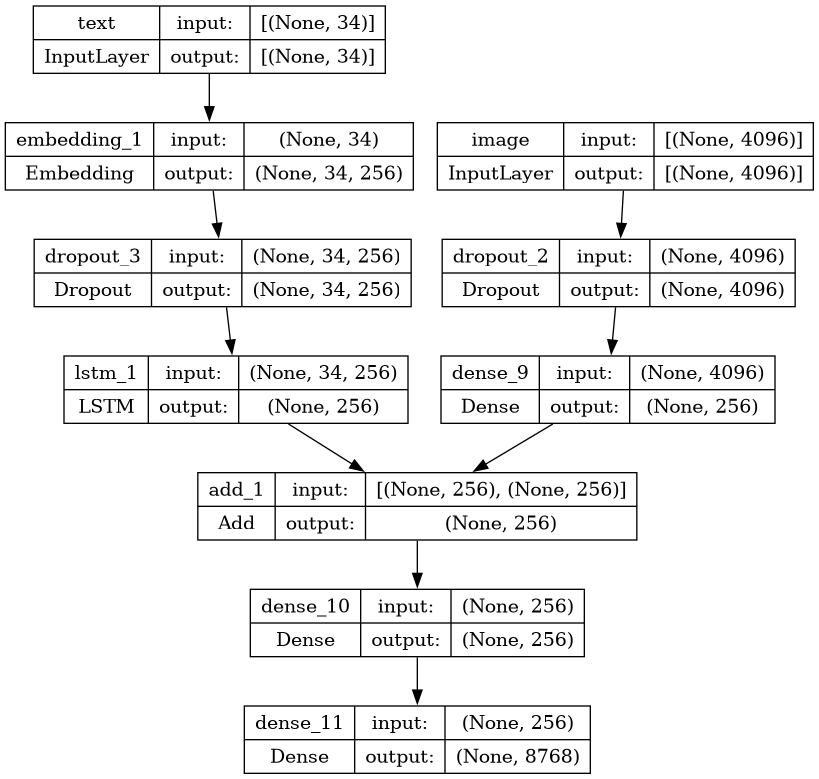

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 34)]                 0         []                            
                                                                                                  
 image (InputLayer)          [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 256)              2244608   ['text[0][0]']                
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['image[0][0]']               
                                                                                            

In [ ]:
import matplotlib.pyplot as plt

epochs = 10
batch_size = 16
steps = len(train) // batch_size

# Initialize lists to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

In [ ]:
for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch and store the history
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, validation_data=(val_data, val_labels), verbose=1)

    # Append the loss and accuracy to the history lists
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    if 'accuracy' in history.history:
        accuracy_history.append(history.history['accuracy'][0])
        val_accuracy_history.append(history.history['val_accuracy'][0])
    elif 'acc' in history.history:
        accuracy_history.append(history.history['acc'][0])
        val_accuracy_history.append(history.history['val_acc'][0])
    else:
        print("Accuracy key not found in history.history")

455/455 [==============================] - 70s 155ms/step - loss: 3.0075 - accuracy: 0.3386 - val_loss: 4.0205 - val_accuracy: 0.3003


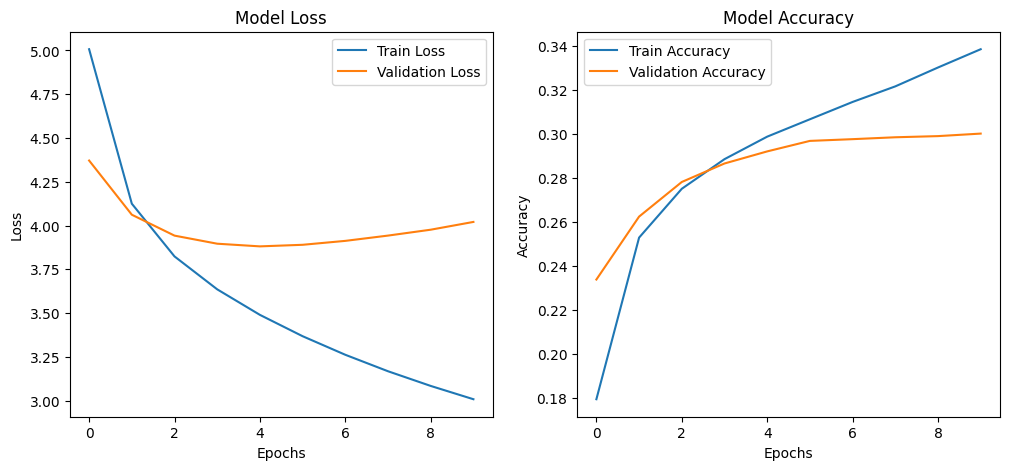

In [ ]:
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('/content/flickr8k/working/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):

    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [07:44<00:00,  1.75it/s]


BLEU-1: 0.479713
BLEU-2: 0.218010


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black and white bird eating seeds out of someone hand endseq
startseq black and white bird standing on hand endseq
startseq small bird sits in person hand and eats seeds endseq
startseq black and white bird standing on hand of someone holding sunflower seeds endseq
startseq the small bird is clinging to finger of the hand holding the seeds endseq
--------------------Predicted--------------------
startseq two dogs play in the snow endseq


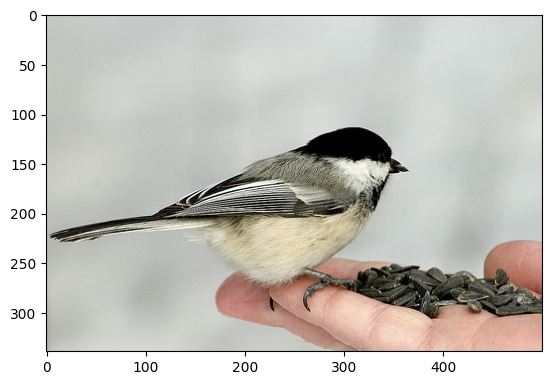

In [ ]:
generate_caption("111766423_4522d36e56.jpg")

In [ ]:
# !mkdir /kaggle/working/image2

In [ ]:
# import requests
# import shutil

# # URL of the image to download
# image_url = 'https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
# # Local filename where the image will be saved
# local_filename = '/kaggle/working/image.jpg'

# # Function to download the image and save it locally
# def download_image(url, filename):
#     response = requests.get(url, stream=True)
#     if response.status_code == 200:
#         with open(filename, 'wb') as out_file:
#             shutil.copyfileobj(response.raw, out_file)
#         print(f"Image successfully downloaded: {filename}")
#     else:
#         print("Error downloading image")

# # Download and save the image
# download_image(image_url, local_filename)

Image successfully downloaded: /kaggle/working/image.jpg


In [ ]:
# import shutil

# # Source file path
# source_file = '/kaggle/working/image.jpg'

# # Destination directory path
# destination_dir = '/kaggle/working/image2/'

# # Ensure the destination directory exists, create if it doesn't
# shutil.os.makedirs(destination_dir, exist_ok=True)

# # Destination file path (including filename)
# destination_file = destination_dir + 'image.jpg'

# # Copy the file
# shutil.copyfile(source_file, destination_file)

# print(f"File copied from '{source_file}' to '{destination_file}' successfully.")

File copied from '/kaggle/working/image.jpg' to '/kaggle/working/image2/image.jpg' successfully.


In [ ]:
# # Assuming you have defined the feature_extractor and directory variables correctly
# directory = '/kaggle/working/image2'
# features_randomImage = extract_features(feature_extractor, directory)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


In [ ]:
# # Define a function to predict caption for a given image features
# def generate_caption_for_image_features(image_features):
#     # Generate caption for the image features
#     predicted_caption = predict_caption(model, image_features, tokenizer, max_length)

#     return predicted_caption

# # Example usage: Use the features extracted for the random image
# image_id = 'image'  # Assuming 'image.jpg' is the image ID
# predicted_caption = generate_caption_for_image_features(features_randomImage[image_id])

# print('--------------------Predicted Caption--------------------')
# print(predicted_caption)

--------------------Predicted Caption--------------------
startseq two dogs are playing in the snow endseq


In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt

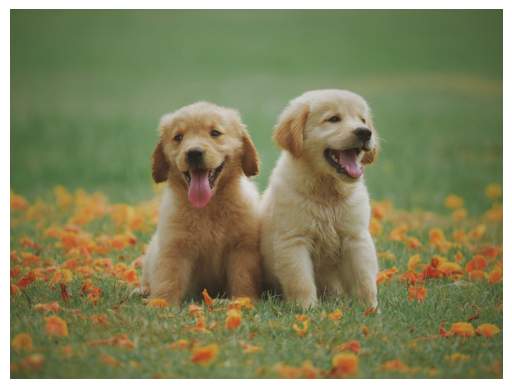

In [ ]:
# image = Image.open('/kaggle/working/image2/image.jpg')
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [ ]:
!mkdir /kaggle/working/image5

In [ ]:
import requests
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt

# List of image URLs - add URL of your choice to check predicted captions
image_urls = [
    'https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
    'https://m.media-amazon.com/images/M/MV5BNmViMTBjYjYtMDllOC00YTk0LWI2Y2ItZjliMjFkMmQxNzZmXkEyXkFqcGdeQXRyYW5zY29kZS13b3JrZmxvdw@@._V1_QL75_UX500_CR0,0,500,281_.jpg',
    'https://motoroctane.com/wp-content/uploads/2017/09/Honda-City-side-1320x778.jpg',
    'https://www.marineinsight.com/wp-content/uploads/2019/08/Cruise-ships-1.png',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6eUcUsjcuvZC94Fbj4-O33pKrVVg4GPJ4Vw&s',
    'https://cdnpt01.viewbug.com/media/mediafiles/2014/12/23/40884211_medium.jpg',
    'https://www.treehugger.com/thmb/Hlt6Q0rgpS17xAkCSqtvUY6_T80=/2121x1414/filters:fill(auto,1)/horse.primary-e9a47e1c486c4fb7bf729e05b59cf0df.jpg',
    'https://images.theconversation.com/files/578175/original/file-20240227-28-cejldv.jpg?ixlib=rb-4.1.0&rect=0%2C0%2C7668%2C3828&q=45&auto=format&w=1356&h=668&fit=crop',
    'https://th.bing.com/th/id/R.7dbf9509b84cfbd918d1deb1ad625da6?rik=PAzXpCKicIDr2g&riu=http%3a%2f%2fwallpapercave.com%2fwp%2fnvOYASN.jpg&ehk=hDEtiRhKOiHeZNWiAaeaKAI9NI8JGkUtxm0%2fP2jriIQ%3d&risl=&pid=ImgRaw&r=0'
]

# Directory to save images
directory_image5 = '/kaggle/working/image5'

# Function to download images
def download_image(url, directory, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        filepath = os.path.join(directory, filename)
        with open(filepath, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        print(f"Image successfully downloaded: {filepath}")
    else:
        print(f"Error downloading image from {url}")

# Create the directory if it doesn't exist
os.makedirs(directory_image5, exist_ok=True)

# Download all images
for idx, url in enumerate(image_urls):
    filename = f'image{idx}.jpg'
    download_image(url, directory_image5, filename)

# Assuming you have defined the feature_extractor and generate_caption_for_image_features function correctly
features_randomImage5 = extract_features(feature_extractor, directory_image5)

# Print all the keys to verify if image_id keys are present
print("Keys in features_randomImage5:", features_randomImage5.keys())

# Example usage: Use the features extracted for the random images
for idx in range(len(image_urls)):
    image_id = f'image{idx}'  # Adjusting the image_id to match keys in features_randomImage5

    if image_id in features_randomImage5:
        predicted_caption = generate_caption_for_image_features(features_randomImage5[image_id])

        print(f'--------------------Predicted Caption for {image_id}.jpg--------------------')
        print(predicted_caption)

        image_path = os.path.join(directory_image5, f'{image_id}.jpg')
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(predicted_caption)
        plt.show()
    else:
        print(f"Error: {image_id} not found in features_randomImage5")